In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
# from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

import matplotlib
matplotlib.rc_file_defaults()
import string

### Load Data 

#### tasmax

In [50]:
# load global data 
tas_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens','CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [51]:
tas_mmle.compute_x(x_type='quantile_return', load=True, name='tasmax_default_quantile_return_10yr_1995_2014')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [52]:
tas_mmle.x.load()
tas_mmle.compute_LE()
tas_mmle.compute_FIT()
internal_tas = tas_mmle.results
tas = tas_mmle.x

#### pr

In [53]:
# load global data 
pr_mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens','CanESM5', 'MPI-ESM1-2-LR','EC-Earth3'],
                                   'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [54]:
pr_mmle.compute_x(x_type='quantile_return', load=True, name='pr_default_quantile_return_10yr_1995_2014')

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [55]:
pr_mmle.x.load()
pr_mmle.compute_LE()
pr_mmle.compute_FIT()
internal_pr = pr_mmle.results
pr = pr_mmle.x

#### picking regions

In [56]:
# region1 = Seattle, region2 = Sydney Australia, region3 = Lagos Nigeria 
regions = ['Seattle', 'Montreal', 'Lagos']
lats = [47.6, 45.5, 6.5]
lons = [237.7, 286.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})

In [57]:
x = xr.merge([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
).drop('q_values') for ds in [tas, pr]])

In [58]:
x = x.to_array()

In [59]:
variable_dim = xr.DataArray(['tasmax', 'pr'], coords={'variable': ['tasmax', 'pr']}, name='variable')

In [60]:
internal = xr.concat([ds.sel(
    lat=xr.DataArray(lats, coords={'region': region_dim}), 
    lon=xr.DataArray(lons, coords={'region': region_dim}), 
    method='nearest'
) for ds in [internal_tas, internal_pr]], dim=variable_dim)

#### get scenario data 

#### tas

In [14]:
# get scenario data
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
scenario_dim = xr.DataArray(scenarios, name='scenario', coords={'scenario': scenarios})

In [15]:
objs_tas, objs_pr = {}, {}
for s in scenarios:
    mmle = MultiModelLargeEnsemble('cmip6', 'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=s,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{s}_tasmax_default_quantile_return_10yr_1995_2014')
    mmle.x = mmle.x.sel(
        lat=xr.DataArray(lats, coords={'region': region_dim}), 
        lon=xr.DataArray(lons, coords={'region': region_dim}), 
        method='nearest'
    )
    mmle.compute_FIT()
    objs_tas[s] = mmle
    
    mmle = MultiModelLargeEnsemble('cmip6', 'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=s,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{s}_pr_default_quantile_return_10yr_1995_2014')
    mmle.x = mmle.x.sel(
        lat=xr.DataArray(lats, coords={'region': region_dim}), 
        lon=xr.DataArray(lons, coords={'region': region_dim}), 
        method='nearest'
    )
    mmle.compute_FIT()
    objs_pr[s] = mmle

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/tasmax.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp126/day/tasmax.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/KACE-1-0-G.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/INM-CM4-8.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/IPSL-CM6A-LR.

In [16]:
cmip_x = xr.merge([xr.concat(
        [objs[s].x for s in scenarios], dim=scenario_dim
    ).drop('q_values')
for objs in [objs_tas, objs_pr]]) 

In [17]:
cmip_x = cmip_x.to_array()

In [18]:
cmip_internal = xr.concat(
    [xr.concat(
        [objs[s].results for s in scenarios], dim=scenario_dim
    ) 
     for objs in [objs_tas, objs_pr]], 
    dim=variable_dim
)

In [19]:
cmip_internal = cmip_internal.load()

### Calculations 

In [61]:
cmip_internal

<xarray.Dataset>
Dimensions:    (variable: 2, model: 14, scenario: 4, region: 3, time: 105)
Coordinates:
  * variable   (variable) <U6 'tasmax' 'pr'
  * model      (model) <U16 'CMCC-CM2-SR5' 'CMCC-ESM2' ... 'NorESM2-MM'
  * scenario   (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * region     (region) <U8 'Seattle' 'Montreal' 'Lagos'
  * time       (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2099-01-01
    lat        (region) float64 47.5 45.0 7.5
    lon        (region) float64 237.5 285.0 2.5
    member_id  <U8 'r1i1p1f1'
    q_values   (variable, model, region) float64 nan nan ... 0.0005227 0.0007296
    quantile   float64 0.9997
Data variables:
    FIT        (variable, scenario, time, model, region) float64 nan ... 4.952
    M_FIT      (variable, scenario, time, region) float64 37.13 60.42 ... 209.3
    I_FIT      (variable, scenario, model, region) float64 nan nan ... 1.062
    Ibar_FIT   (variable, scenario, region) float64 13.18 13.51 ... 1.907 4.65
    T_FIT      (variable, scenario, time, region) float64 nan nan ... nan nan

In [62]:
# scenario uncertainty 
# %%time
internal['S'] = cmip_x.mean(('model')).var('scenario').compute()

In [63]:
internal = internal.drop('member_id')

In [64]:
internal = internal.squeeze('member_id')

In [65]:
ref = x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model'))

In [66]:
signal = x.mean(('member_id', 'model')) - ref

In [67]:
# find signal max
change_tas = (x.isel(variable=0,time=-6) - x.isel(variable=0,time=20))
change_pr = (x.isel(variable=1,time=-6) - x.isel(variable=1,time=20))

In [39]:
change_tas.isel(region=0).mean('member_id')

<xarray.DataArray (model: 4)>
array([101.52      ,  48.375     , 148.7       ,  92.98275862])
Coordinates:
  * model     (model) <U13 'MIROC6' 'cesm_lens' 'MPI-ESM1-2-LR' 'EC-Earth3'
    lat       float64 47.5
    lon       float64 237.5
    quantile  (model) float64 0.9997 0.9997 0.9997 0.9997
    region    <U8 'Seattle'
    variable  <U6 'tasmax'

In [40]:
# for without CanESM5
signalmax_tas_lagos = x.sel(model='EC-Earth3',variable='tasmax').mean('member_id') - ref
signalmax_tas_montreal = x.sel(model='cesm_lens',variable='tasmax').mean('member_id') - ref

signalmax_tas_seattle = x.sel(model='MPI-ESM1-2-LR',variable='tasmax').mean('member_id') - ref
signalmax_pr_lagos = x.sel(model='MPI-ESM1-2-LR',variable='pr').mean('member_id') - ref
signalmax_pr_seattle = x.sel(model='cesm_lens',variable='pr').mean('member_id') - ref
signalmax_pr_montreal = x.sel(model='EC-Earth3',variable='pr').mean('member_id') - ref

In [29]:
# # with CanESM5
# signalmax_pr_lagos = x.sel(model='MPI-ESM1-2-LR',variable='pr').mean('member_id') - ref
# signal_max = x.sel(model='CanESM5').mean('member_id') - ref

### Plots

In [81]:
x = x.assign_coords({'model':['MIROC6','CESM_LE','CanESM5','MPI-ESM1-2-LR','EC-Earth3']})

In [86]:
internal = internal.assign_coords({'model':['MIROC6','CESM_LE','CanESM5','MPI-ESM1-2-LR','EC-Earth3']})

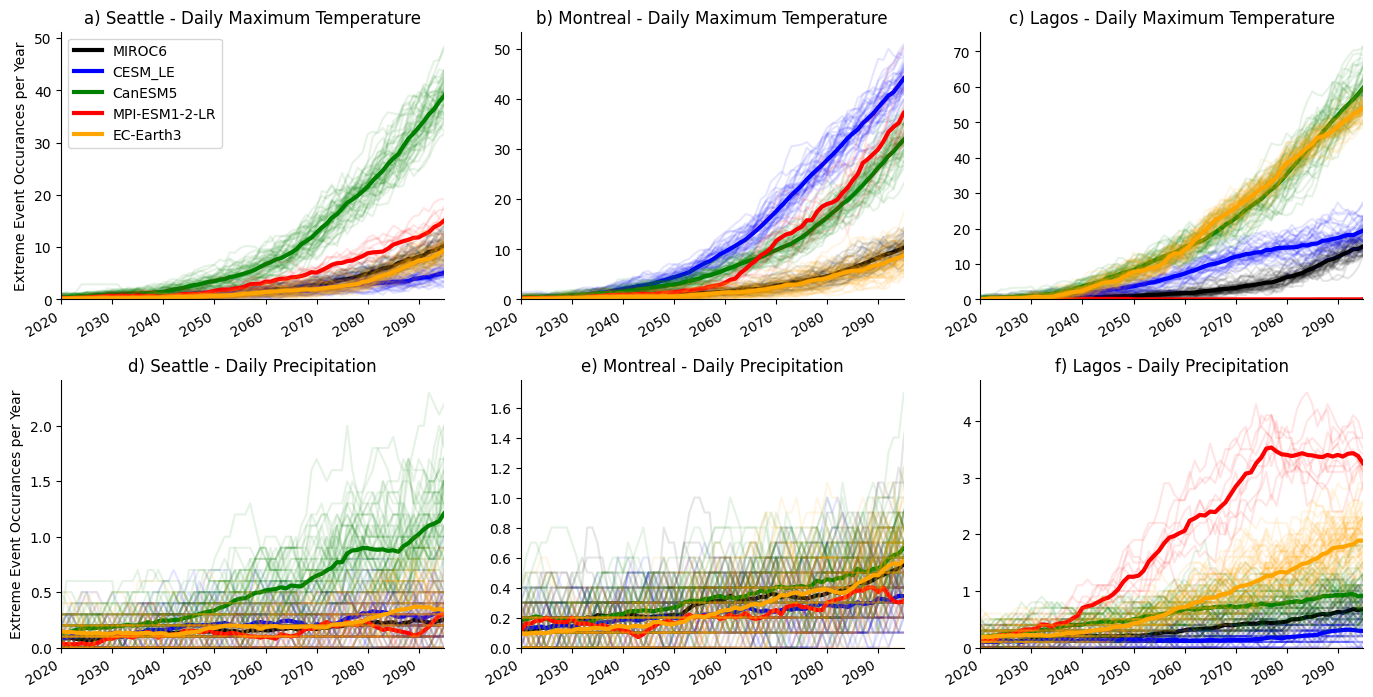

In [83]:
# Figure 1
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))
count = 0
for iv, v in enumerate(x['variable'].values):
    for ir, r in enumerate(x.region.values):
        ax = axs[iv, ir]
        for im, m in enumerate(x.model.values):
            ((x.sel(variable=v, region=r, model=m).mean('member_id'))/10).plot(ax=ax, lw=3, c=colors[im], label=m)
            ((x.sel(variable=v, region=r, model=m))/10).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
            # ax.spines["bottom"].set_position(("axes", -0.03)) 
            # ax.spines["left"].set_position(("axes", -0.02))
    #         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Extreme Event Occurances per Year')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/region_x_ensemble.png', dpi=200)

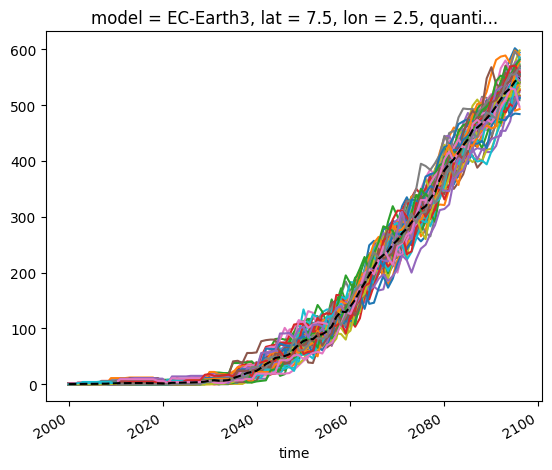

In [131]:
x.isel(variable=0,region=2,model=3).plot(hue='member_id',add_legend=False);
x.isel(variable=0,region=2,model=3).mean('member_id').plot(color='k',ls='dashed')

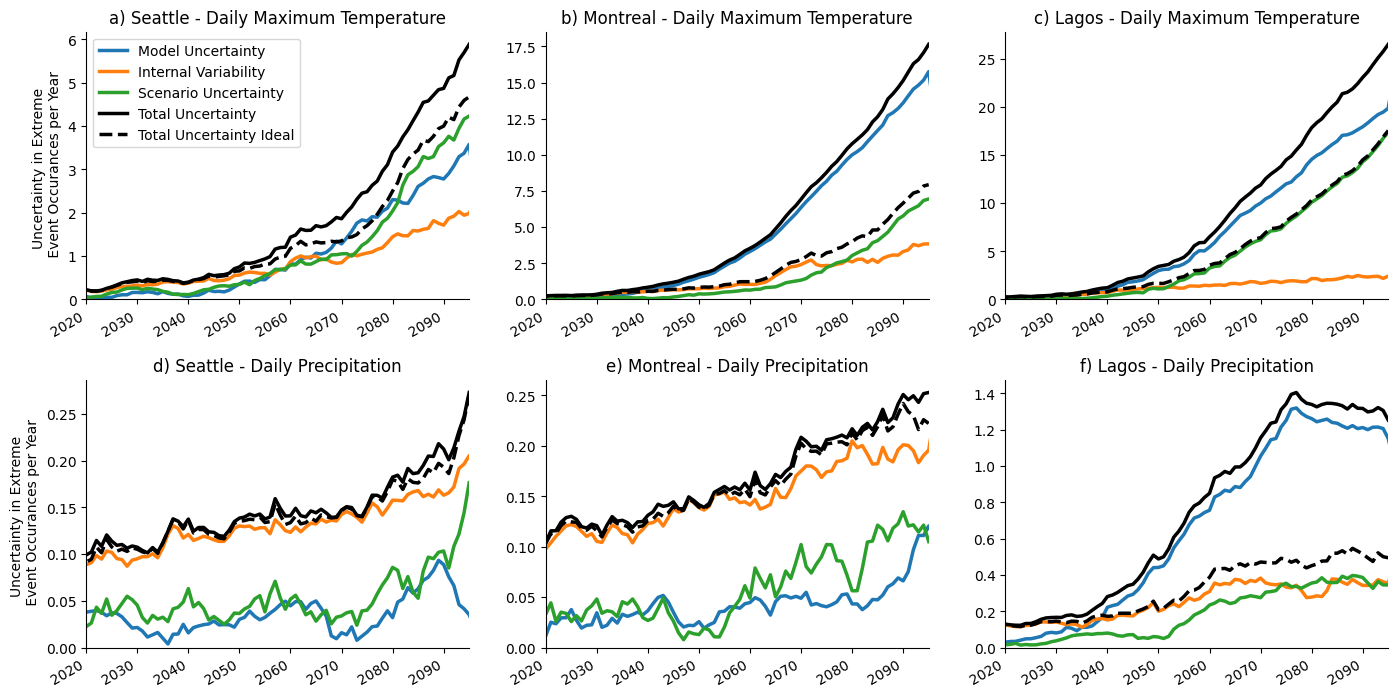

In [31]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        total = internal.M_LE + internal.Ibar_LE +internal.S
        total_ideal = internal.Ibar_LE +internal.S
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).M_LE))/10).plot(ax=ax, lw=2.5,label='Model Uncertainty')
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).Ibar_LE))/10).plot(ax=ax, lw=2.5,label='Internal Variability')
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).S))/10).plot(ax=ax, lw=2.5,label='Scenario Uncertainty')
        ((xr.ufuncs.sqrt(total.sel(variable=v, region=r)))/10).plot(ax=ax,lw=2.5,label='Total Uncertainty',color='k')
        ((xr.ufuncs.sqrt(total_ideal.sel(variable=v, region=r)))/10).plot(ax=ax,lw=2.5,label='Total Uncertainty Ideal',color='k',linestyle='dashed')
            # x.sel(variable=v, region=r, model=m).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per Year')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/std_uncertainties_scenario.png', dpi=200)

In [32]:
# from IPython.display import Image
# Image(filename='./plots/std_uncertainties_scenario.png')   # Don't believe what Jupyter shows you!

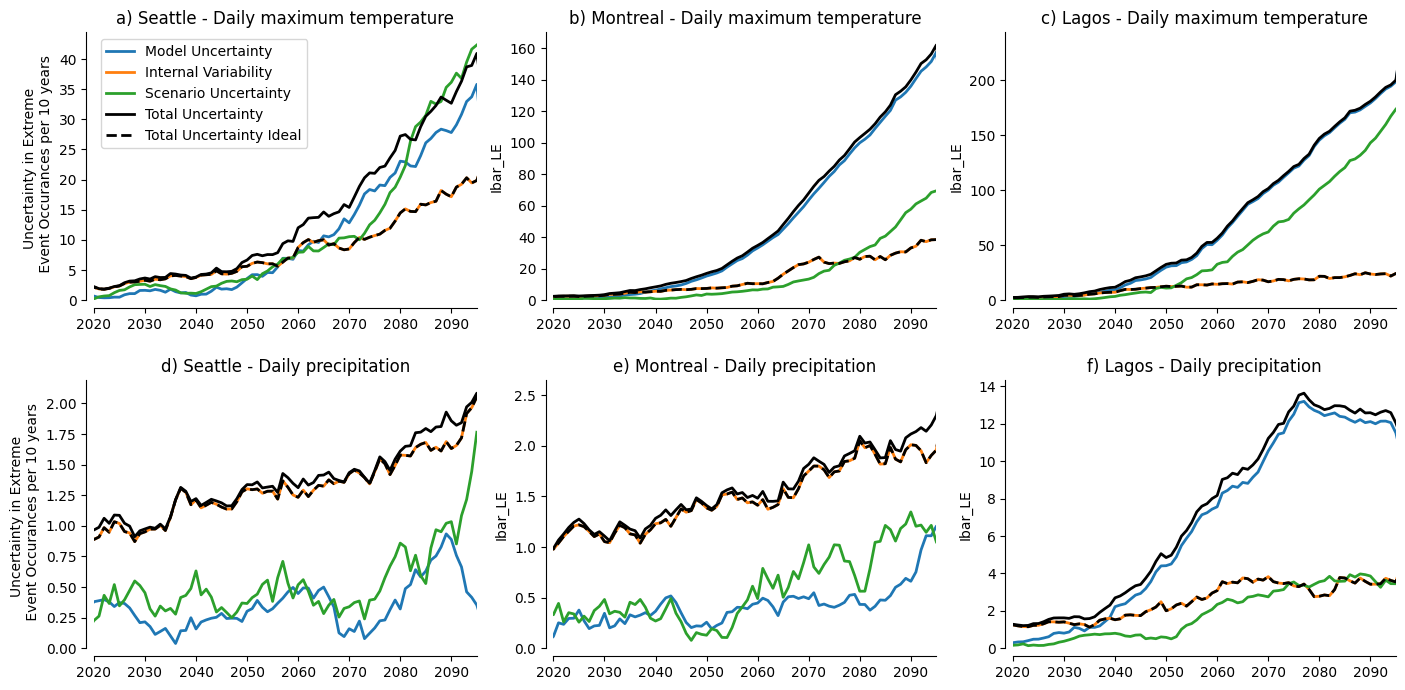

In [32]:
# same as above but without S in total uncertainty 
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily maximum temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        total = internal.M_LE + internal.Ibar_LE 
        total_ideal = internal.Ibar_LE 
        xr.ufuncs.sqrt(internal.sel(variable=v, region=r).M_LE).plot(ax=ax, lw=2,label='Model Uncertainty')
        xr.ufuncs.sqrt(internal.sel(variable=v, region=r).Ibar_LE).plot(ax=ax, lw=2,label='Internal Variability')
        xr.ufuncs.sqrt(internal.sel(variable=v, region=r).S).plot(ax=ax, lw=2,label='Scenario Uncertainty')
        xr.ufuncs.sqrt(total.sel(variable=v, region=r)).plot(ax=ax,lw=2,label='Total Uncertainty',color='k')
        xr.ufuncs.sqrt(total_ideal.sel(variable=v, region=r)).plot(ax=ax,lw=2,label='Total Uncertainty Ideal',color='k',linestyle='dashed')
            # x.sel(variable=v, region=r, model=m).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per 10 years')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/std_uncertainties_noscenario.png', dpi=200)

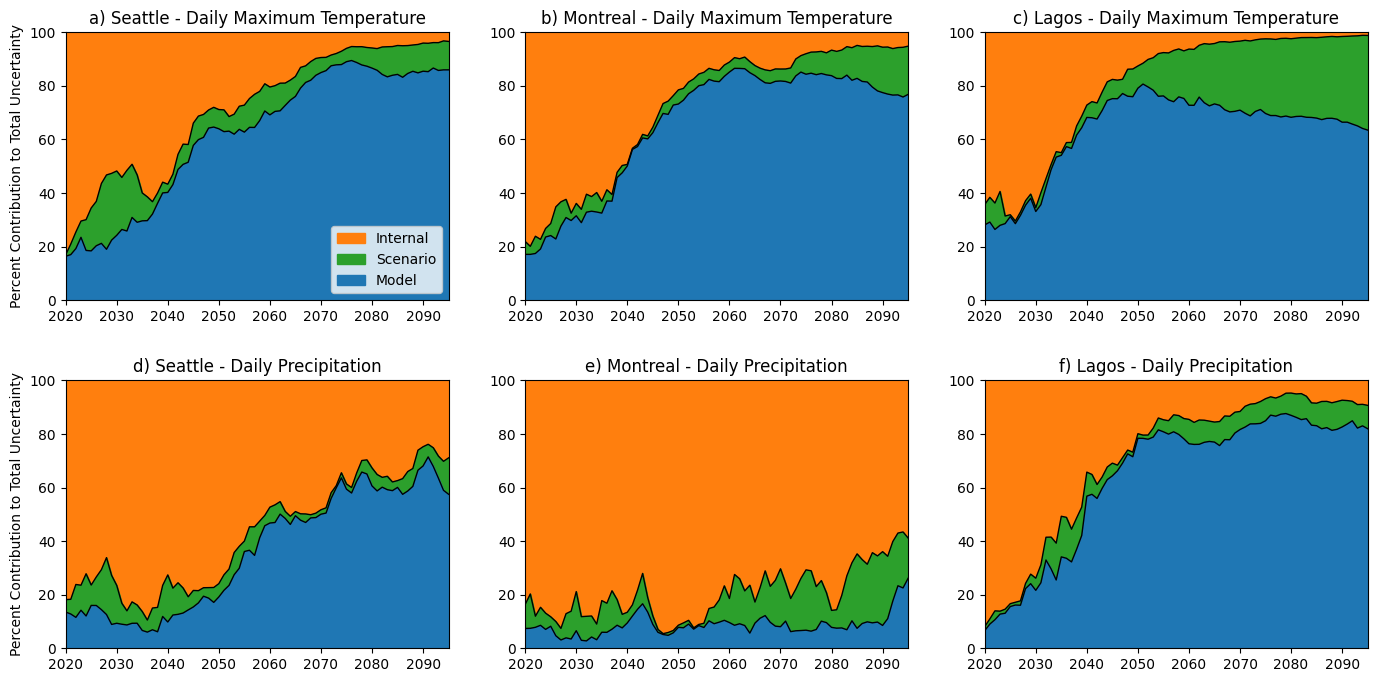

In [88]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        total = internal.M_LE + internal.Ibar_LE + internal.S
        M_frac = (internal.M_LE / total) *100
        I_frac = (internal.Ibar_LE / total) * 100 
        S_frac = (internal.S / total) *100
        
        time = internal.sel(variable=v,region=r).time
        y1 = M_frac.sel(variable=v,region=r)
        y2 = y1 + S_frac.sel(variable=v,region=r)
        ax.fill_between(time,y2,100,label='Internal',color='#ff7f0e')
        ax.fill_between(time,y1,y2,label='Scenario',color='#2ca02c')
        ax.fill_between(time,0,y1,label='Model',color='#1f77b4')
        ax.plot(time,y1,color='k',linewidth=1)
        ax.plot(time,y2,color='k',linewidth=1)
            # x.sel(variable=v, region=r, model=m).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0,top=100)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        # ax.spines.right.set_visible(False)
        # ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend(loc=4)
for ax in axs[:, 0]:
    ax.set_ylabel('Percent Contribution to Total Uncertainty')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/percent_contribution.png', dpi=200)

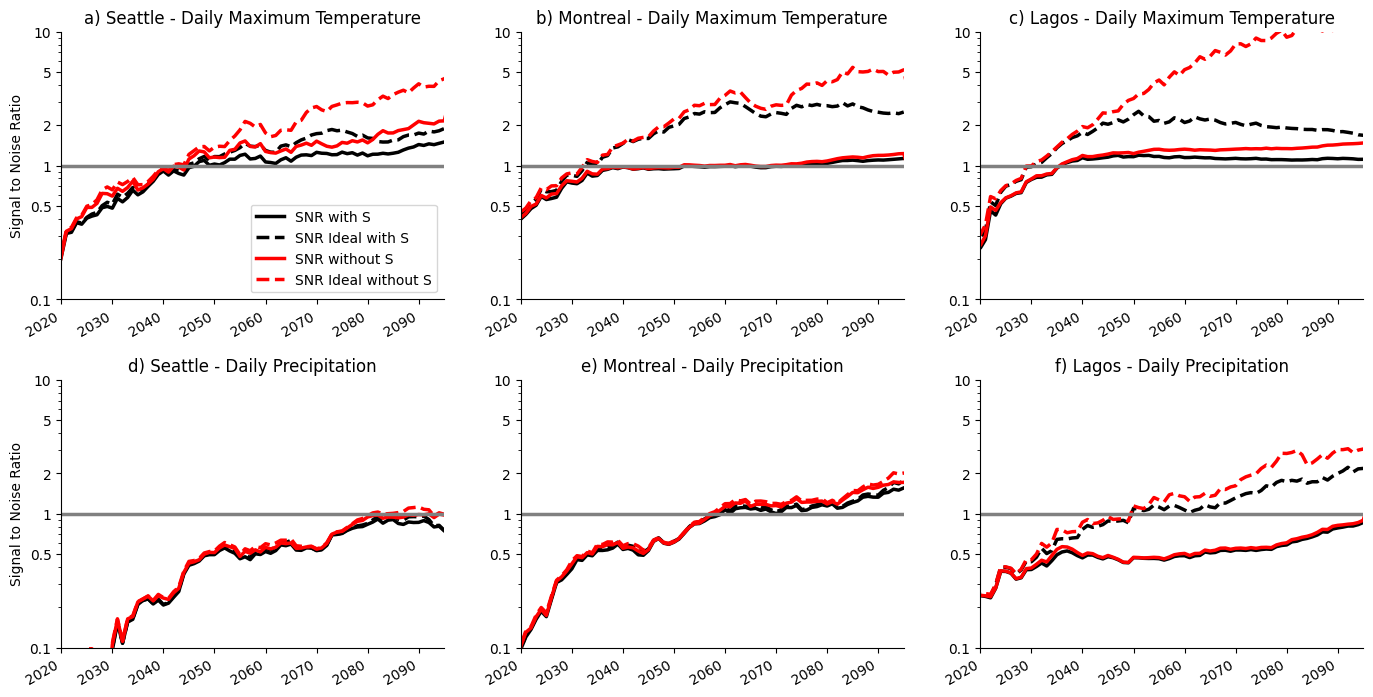

In [34]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        total = internal.M_LE + internal.Ibar_LE + internal.S
        total_ideal = internal.Ibar_LE + internal.S
        SNR = np.abs(signal/ np.sqrt(total))
        SNR_ideal = np.abs(signal/ np.sqrt(total_ideal))
        
        total1 = internal.M_LE + internal.Ibar_LE 
        total_ideal1 = internal.Ibar_LE 
        SNR1 = np.abs(signal/ np.sqrt(total1))
        SNR_ideal1 = np.abs(signal/ np.sqrt(total_ideal1))
        
        SNR.sel(variable=v,region=r).plot(ax=ax, lw=2.5, label='SNR with S',color='k')
        SNR_ideal.sel(variable=v,region=r).plot(ax=ax, lw=2.5, label='SNR Ideal with S',linestyle='dashed',color='k')
        SNR1.sel(variable=v,region=r).plot(ax=ax, lw=2.5, label='SNR without S',color='r')
        SNR_ideal1.sel(variable=v,region=r).plot(ax=ax, lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')
        
        ax.axhline(1,color='gray',linewidth=2.5)
        
            # x.sel(variable=v, region=r, model=m).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        # ax.set_ylim(bottom=0)
        ax.set_yscale('log')
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Signal to Noise Ratio')
for ax in axs[0,:]:
    ax.set_ylim(0.1,10)
    yticks = [0.1,0.5,1,2,5,10]
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(yticks)
for ax in axs[1,:]:
    ax.set_ylim(0.1,10)
    yticks = [0.1,0.5,1,2,5,10]
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(yticks)
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/SNR_regions.png', dpi=200)

In [77]:
cmip_internal.model

<xarray.DataArray 'model' (model: 14)>
array(['CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3', 'EC-Earth3-Veg-LR',
       'GFDL-ESM4', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NorESM2-MM'],
      dtype='<U16')
Coordinates:
  * model      (model) <U16 'CMCC-CM2-SR5' 'CMCC-ESM2' ... 'NorESM2-MM'
    member_id  <U8 'r1i1p1f1'
    quantile   float64 0.9997

In [32]:
# # SNR with signal max - with CanESM5
# colors = ['k','b','g','r','orange']
# var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
# fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

# total = internal.M_LE + internal.Ibar_LE + internal.S
# total_ideal = internal.Ibar_LE + internal.S
# SNR = np.abs(signal_max/ np.sqrt(total))
# SNR_ideal = np.abs(signal_max/ np.sqrt(total_ideal))
        
# total1 = internal.M_LE + internal.Ibar_LE 
# total_ideal1 = internal.Ibar_LE 
# SNR1 = np.abs(signal_max/ np.sqrt(total1))
# SNR_ideal1 = np.abs(signal_max/ np.sqrt(total_ideal1))
        
# total_lagos = internal.M_LE + internal.Ibar_LE + internal.S
# total_ideal_lagos = internal.Ibar_LE + internal.S
# SNR_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total_lagos))
# SNR_ideal_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total_ideal_lagos))
        
# total1_lagos = internal.M_LE + internal.Ibar_LE 
# total_ideal1_lagos = internal.Ibar_LE 
# SNR1_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total1_lagos))
# SNR_ideal1_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total_ideal1_lagos))

# axes = [axs[0,0],axs[0,1],axs[0,2]]
# regions = ['Seattle','Sydney','Lagos']
# for axis,r in zip(axes,regions):
#     SNR.sel(variable='tasmax',region=r).plot(ax=axis, lw=2, label='SNR with S',color='k')
#     SNR_ideal.sel(variable='tasmax',region=r).plot(ax=axis, lw=2, label='SNR Ideal with S',color='k',linestyle='dashed')
#     SNR1.sel(variable='tasmax',region=r).plot(ax=axis, lw=2, label='SNR without S',color='r')
#     SNR_ideal1.sel(variable='tasmax',region=r).plot(ax=axis, lw=2, label='SNR Ideal without S',color='r',linestyle='dashed')
    
# axes = [axs[1,0],axs[1,1]]
# regions = ['Seattle','Sydney']
# for axis,r in zip(axes,regions):
#     SNR.sel(variable='pr',region=r).plot(ax=axis, lw=2, label='SNR with S',color='k')
#     SNR_ideal.sel(variable='pr',region=r).plot(ax=axis, lw=2, label='SNR Ideal with S',color='k',linestyle='dashed')
#     SNR1.sel(variable='pr',region=r).plot(ax=axis, lw=2, label='SNR without S',color='r')
#     SNR_ideal1.sel(variable='pr',region=r).plot(ax=axis, lw=2, label='SNR Ideal without S',color='r',linestyle='dashed')
        
# SNR_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2, label='SNR with S',color='k')
# SNR_ideal_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2, label='SNR Ideal with S',color='k',linestyle='dashed')
# SNR1_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2, label='SNR without S',color='r')
# SNR_ideal1_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2, label='SNR Ideal without S',color='r',linestyle='dashed')

# count = 0
# for iv, v in enumerate(internal['variable'].values):
#     for ir, r in enumerate(internal.region.values):
#         ax = axs[iv, ir]
#         ax.axhline(1,color='gray',linewidth=2)
#         ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
#         # ax.set_ylim(bottom=0)
#         ax.set_yscale('log')
#         ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
#         ax.set_xlabel('')
#         ax.spines.right.set_visible(False)
#         ax.spines.top.set_visible(False)
#         ax.spines["bottom"].set_position(("axes", -0.03)) 
#         ax.spines["left"].set_position(("axes", -0.02))
# #         ax.set_facecolor('0.95')
#         count += 1
# axs[0, 0].legend()
# for ax in axs[:, 0]:
#     ax.set_ylabel('Signal to Noise Ratio')
# for ax in axs[0,:]:
#     ax.set_ylim(0.1,100)
#     yticks = [0.1,0.5,1,2,5,10,100]
#     ax.set_yticks(ticks=yticks)
# for ax in axs[1,:]:
#     ax.set_ylim(0.1,100)
#     yticks = [0.1,0.5,1,2,5,10,100]
#     ax.set_yticks(ticks=yticks)
# plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# # fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# fig.savefig('./plots/SNR_signalmax_regions.png', dpi=200)

In [41]:
# for without CanESM5
SNR_lagos = np.abs(signalmax_tas_lagos/ np.sqrt(total))
SNR_ideal_lagos = np.abs(signalmax_tas_lagos/ np.sqrt(total_ideal))   # tas lagos
        
SNR1_lagos = np.abs(signalmax_tas_lagos/ np.sqrt(total1))
SNR_ideal1_lagos = np.abs(signalmax_tas_lagos/ np.sqrt(total_ideal1))

SNR_montreal = np.abs(signalmax_tas_montreal/ np.sqrt(total))
SNR_ideal_montreal = np.abs(signalmax_tas_montreal/ np.sqrt(total_ideal))   # tas montreal
        
SNR1_montreal = np.abs(signalmax_tas_montreal/ np.sqrt(total1))
SNR_ideal1_montreal = np.abs(signalmax_tas_montreal/ np.sqrt(total_ideal1))


SNR_seattle = np.abs(signalmax_tas_seattle/ np.sqrt(total))
SNR_ideal_seattle = np.abs(signalmax_tas_seattle/ np.sqrt(total_ideal))  # tas seattle
        

SNR1_seattle = np.abs(signalmax_tas_seattle/ np.sqrt(total1))
SNR_ideal1_seattle = np.abs(signalmax_tas_seattle/ np.sqrt(total_ideal1))
        

SNR_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total))     # pr lagos
SNR_ideal_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total_ideal))
        

SNR1_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total1))
SNR_ideal1_lagos = np.abs(signalmax_pr_lagos/ np.sqrt(total_ideal1))


SNR_montreal = np.abs(signalmax_pr_montreal/ np.sqrt(total))      #pr montreal
SNR_ideal_montreal = np.abs(signalmax_pr_montreal/ np.sqrt(total_ideal))
        

SNR1_montreal = np.abs(signalmax_pr_montreal/ np.sqrt(total1))
SNR_ideal1_montreal = np.abs(signalmax_pr_montreal/ np.sqrt(total_ideal1))

SNR_seattle_pr = np.abs(signalmax_pr_seattle/ np.sqrt(total))       # pr seattle
SNR_ideal_seattle_pr = np.abs(signalmax_pr_seattle/ np.sqrt(total_ideal))
        
SNR1_seattle_pr = np.abs(signalmax_pr_seattle/ np.sqrt(total1))
SNR_ideal1_seattle_pr = np.abs(signalmax_pr_seattle/ np.sqrt(total_ideal1))

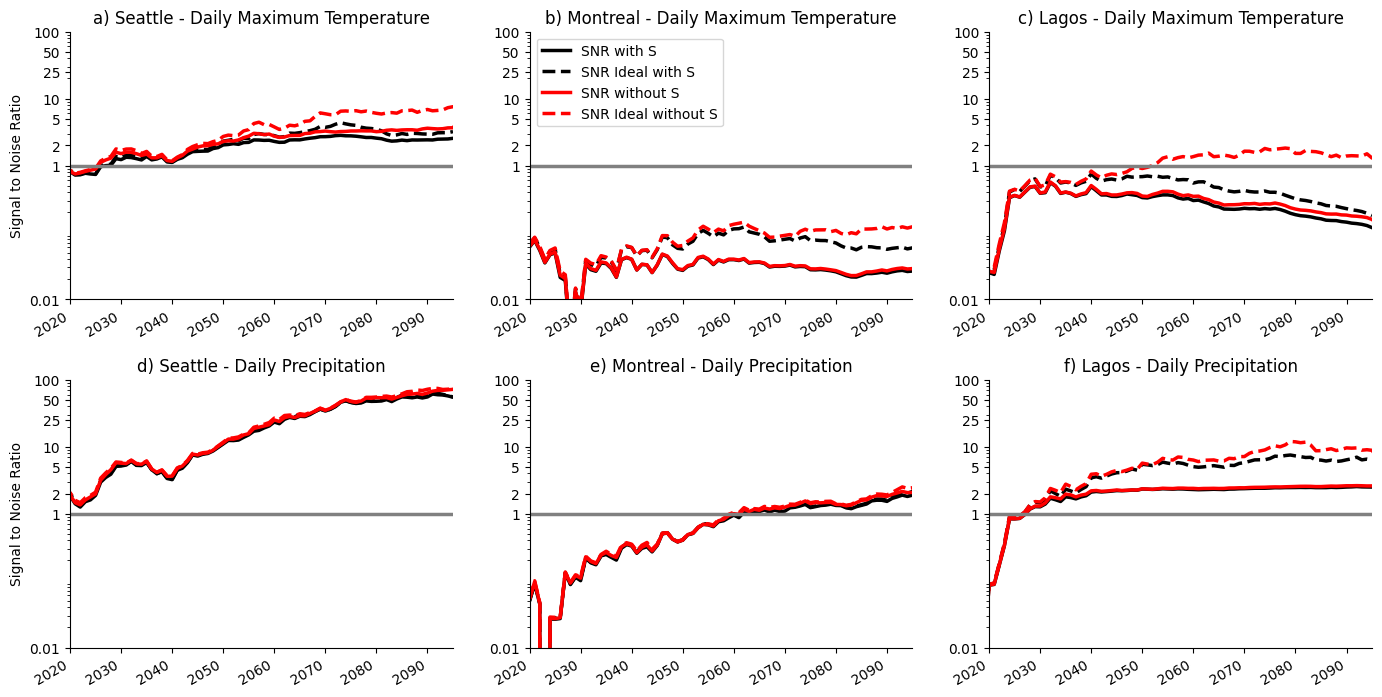

In [46]:
# SNR with signal max without CanESM5 model 
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

SNR_seattle.sel(variable='tasmax',region='Seattle').plot(ax=axs[0,0], lw=2.5, label='SNR with S',color='k')
SNR_ideal_seattle.sel(variable='tasmax',region='Seattle').plot(ax=axs[0,0], lw=2.5, label='SNR Ideal with S',color='k',linestyle='dashed')
SNR1_seattle.sel(variable='tasmax',region='Seattle').plot(ax=axs[0,0], lw=2.5, label='SNR without S',color='r')
SNR_ideal1_seattle.sel(variable='tasmax',region='Seattle').plot(ax=axs[0,0], lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')

SNR_seattle.sel(variable='pr',region='Seattle').plot(ax=axs[1,0], lw=2.5, label='SNR with S',color='k')
SNR_ideal_seattle.sel(variable='pr',region='Seattle').plot(ax=axs[1,0], lw=2.5, label='SNR Ideal with S',color='k',linestyle='dashed')
SNR1_seattle.sel(variable='pr',region='Seattle').plot(ax=axs[1,0], lw=2.5, label='SNR without S',color='r')
SNR_ideal1_seattle.sel(variable='pr',region='Seattle').plot(ax=axs[1,0], lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')

SNR_montreal.sel(variable='pr',region='Montreal').plot(ax=axs[1,1], lw=2.5, label='SNR with S',color='k')
SNR_ideal_montreal.sel(variable='pr',region='Montreal').plot(ax=axs[1,1], lw=2.5, label='SNR Ideal with S',color='k',linestyle='dashed')
SNR1_montreal.sel(variable='pr',region='Montreal').plot(ax=axs[1,1], lw=2.5, label='SNR without S',color='r')
SNR_ideal1_montreal.sel(variable='pr',region='Montreal').plot(ax=axs[1,1], lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')

SNR_montreal.sel(variable='tasmax',region='Montreal').plot(ax=axs[0,1], lw=2.5, label='SNR with S',color='k')
SNR_ideal_montreal.sel(variable='tasmax',region='Montreal').plot(ax=axs[0,1], lw=2.5, label='SNR Ideal with S',color='k',linestyle='dashed')
SNR1_montreal.sel(variable='tasmax',region='Montreal').plot(ax=axs[0,1], lw=2.5, label='SNR without S',color='r')
SNR_ideal1_montreal.sel(variable='tasmax',region='Montreal').plot(ax=axs[0,1], lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')
        
SNR_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2.5, label='SNR with S',color='k')
SNR_ideal_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2.5, label='SNR Ideal with S',color='k',linestyle='dashed')
SNR1_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2.5, label='SNR without S',color='r')
SNR_ideal1_lagos.sel(variable='pr',region='Lagos').plot(ax=axs[1,2], lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')

SNR_lagos.sel(variable='tasmax',region='Lagos').plot(ax=axs[0,2], lw=2.5, label='SNR with S',color='k')
SNR_ideal_lagos.sel(variable='tasmax',region='Lagos').plot(ax=axs[0,2], lw=2.5, label='SNR Ideal with S',color='k',linestyle='dashed')
SNR1_lagos.sel(variable='tasmax',region='Lagos').plot(ax=axs[0,2], lw=2.5, label='SNR without S',color='r')
SNR_ideal1_lagos.sel(variable='tasmax',region='Lagos').plot(ax=axs[0,2], lw=2.5, label='SNR Ideal without S',color='r',linestyle='dashed')

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        ax.axhline(1,color='gray',linewidth=2.5)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        # ax.set_ylim(bottom=0)
        ax.set_yscale('log')
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 1].legend(loc=2)
for ax in axs[:, 0]:
    ax.set_ylabel('Signal to Noise Ratio')
for ax in axs[0,:]:
    ax.set_ylim(0.01,100)
    yticks = [0.01,1,2,5,10,25,50,100]
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(yticks)
for ax in axs[1,:]:
    ax.set_ylim(0.01,100)
    yticks = [0.01,1,2,5,10,25,50,100]
    ax.set_yticks(ticks=yticks)
    ax.set_yticklabels(yticks)
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/SNR_signalmax_regions.png', dpi=200)

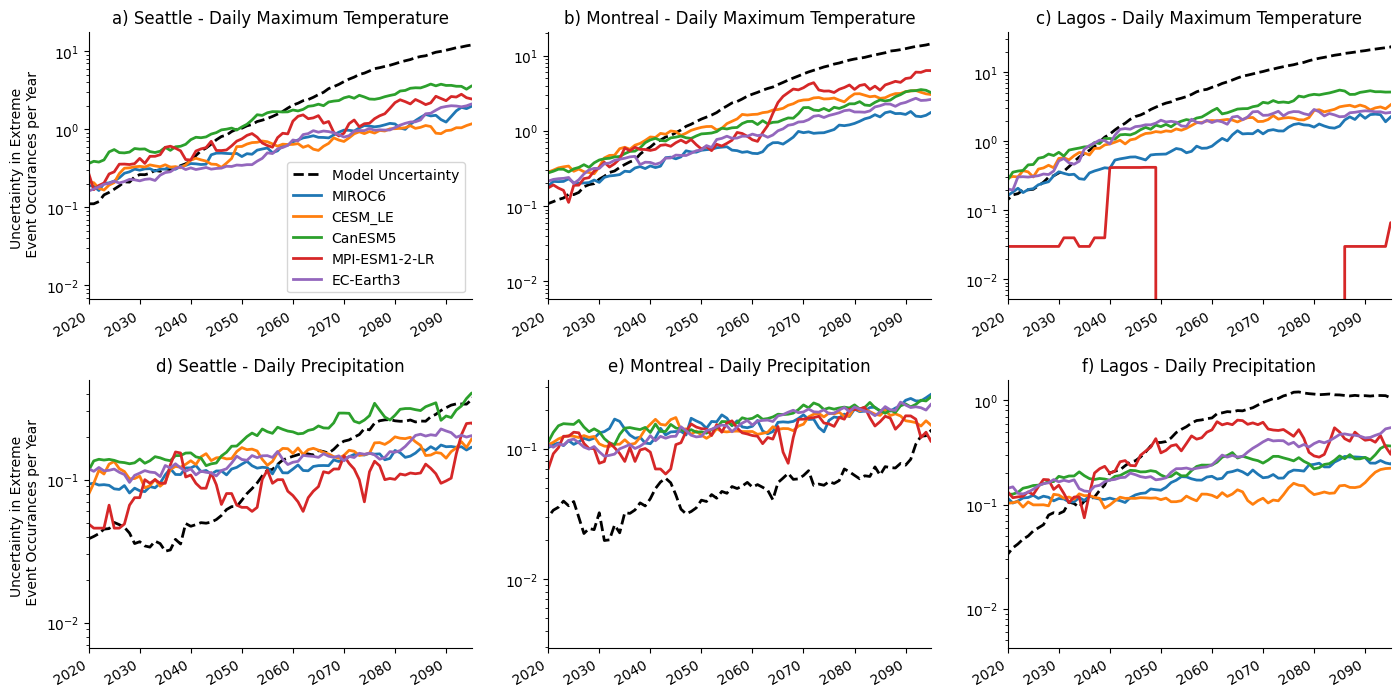

In [84]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        # for im, m in enumerate(internal.model.values):
        total = internal.M_LE + internal.Ibar_LE +internal.S
        total_ideal = internal.Ibar_LE +internal.S
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).M_LE))/10).plot(ax=ax, lw=2,linestyle='dashed',color='k')
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).I_LE))/10).plot(ax=ax, hue='model',lw=2,add_legend=False)
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_yscale('log')
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
labels = ['Model Uncertainty','MIROC6', 'CESM_LE', 'CanESM5','MPI-ESM1-2-LR', 'EC-Earth3']
axs[0, 0].legend(labels=labels)
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per Year')
for ax in axs[:, 1]:
    ax.set_ylabel('')
for ax in axs[:, 2]:
    ax.set_ylabel('')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/LE_internal_model.png', dpi=200)

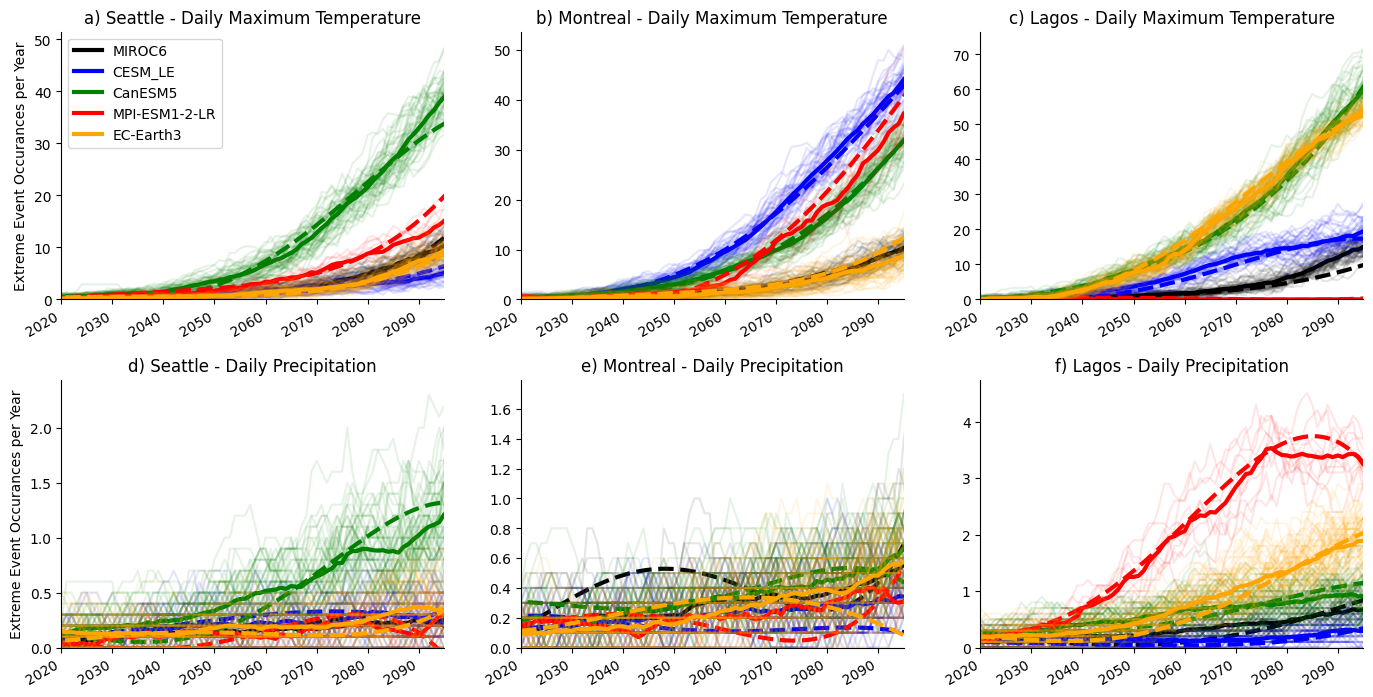

In [87]:
# Figure 1
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(x['variable'].values):
    for ir, r in enumerate(x.region.values):
        ax = axs[iv, ir]
        for im, m in enumerate(x.model.values):
            ((x.sel(variable=v, region=r, model=m).mean('member_id'))/10).plot(ax=ax, lw=3, c=colors[im], label=m)
            ((x.sel(variable=v, region=r, model=m))/10).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
            ((internal.sel(variable=v,region=r, model=m).FIT)/10).plot(ax=ax,c=colors[im],lw=3,linestyle='dashed')
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Extreme Event Occurances per Year')
for ax in axs[:, 1]:
    ax.set_ylabel('')
for ax in axs[:, 2]:
    ax.set_ylabel('')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/region_x_ensemble_firstmember.png', dpi=200)

In [47]:
cmip_internal

<xarray.Dataset>
Dimensions:    (variable: 2, model: 14, scenario: 4, region: 3, time: 105)
Coordinates:
  * variable   (variable) <U6 'tasmax' 'pr'
  * model      (model) <U16 'CMCC-CM2-SR5' 'CMCC-ESM2' ... 'NorESM2-MM'
  * scenario   (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * region     (region) <U7 'Seattle' 'Sydney' 'Lagos'
  * time       (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2099-01-01
    lat        (region) float64 47.5 -35.0 7.5
    lon        (region) float64 237.5 150.0 2.5
    member_id  <U8 'r1i1p1f1'
    q_values   (variable, model, region) float64 nan nan ... 0.001181 0.0007296
    quantile   float64 0.9997
Data variables:
    FIT        (variable, scenario, time, model, region) float64 nan ... 4.952
    M_FIT      (variable, scenario, time, region) float64 37.13 25.56 ... 209.3
    I_FIT      (variable, scenario, model, region) float64 nan nan ... 1.062
    Ibar_FIT   (variable, scenario, region) float64 13.18 12.05 ... 0.9731 4.65
    T_FIT      (variable, scenario, time, region) float64 nan nan ... nan nan

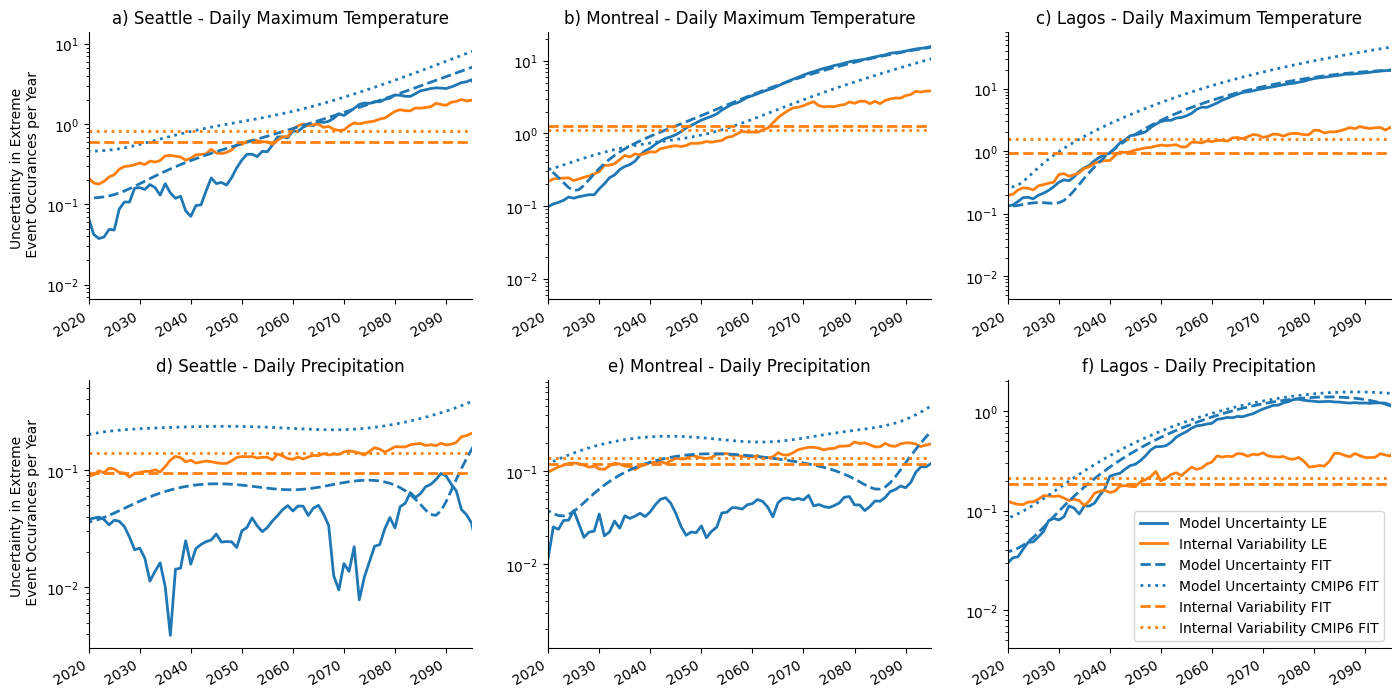

In [47]:
colors = ['k','b','g','r','orange']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(internal['variable'].values):
    for ir, r in enumerate(internal.region.values):
        ax = axs[iv, ir]
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).M_LE))/10).plot(ax=ax, lw=2,label='Model Uncertainty LE',color='#1f77b4')
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).Ibar_LE))/10).plot(ax=ax, lw=2,label='Internal Variability LE',color='#ff7f0e')
        ((xr.ufuncs.sqrt(internal.sel(variable=v, region=r).M_FIT))/10).plot(ax=ax, lw=2,label='Model Uncertainty FIT',color='#1f77b4',linestyle='dashed')
        ((xr.ufuncs.sqrt(cmip_internal.sel(variable=v, region=r,scenario='ssp585').M_FIT))/10).plot(ax=ax, lw=2,label='Model Uncertainty CMIP6 FIT',color='#1f77b4',
                                                                                                    linestyle='dotted')
        ax.axhline(((xr.ufuncs.sqrt(internal.sel(variable=v,region=r).Ibar_FIT)/10)),label='Internal Variability FIT',color='#ff7f0e',ls='--',lw=2)
        ax.axhline(((xr.ufuncs.sqrt(cmip_internal.sel(variable=v,region=r,scenario='ssp585').Ibar_FIT)/10)),label='Internal Variability CMIP6 FIT',color='#ff7f0e',
                   ls='dotted',lw=2)
        ax.set_yscale('log')
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[1, 2].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per Year')
for ax in axs[:, 1]:
    ax.set_ylabel('')
for ax in axs[:, 2]:
    ax.set_ylabel('')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/FITvsLE.png', dpi=200)

In [40]:
cmip_internal = cmip_internal.load()

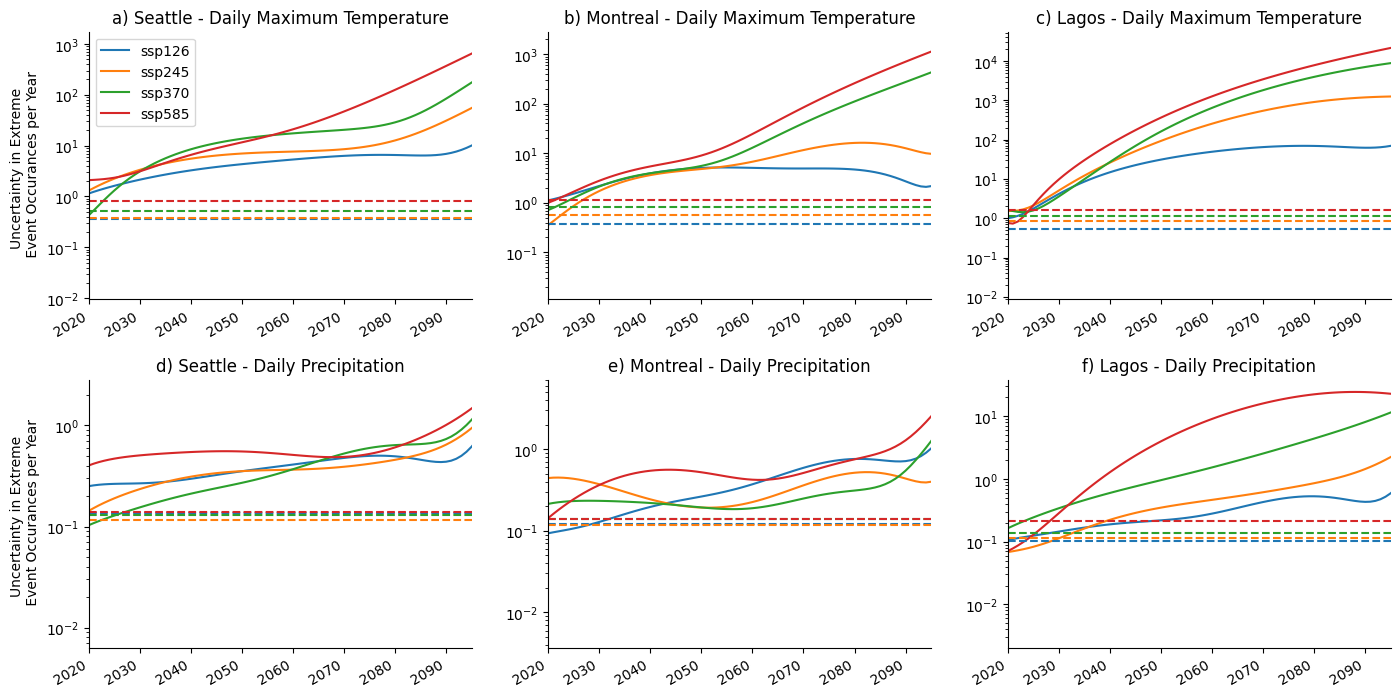

In [48]:
colors = ['k','b','g','r']
var_dict = {'tasmax': 'Daily Maximum Temperature', 'pr': 'Daily Precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=3, constrained_layout=True,figsize=(14,7))

count = 0
for iv, v in enumerate(cmip_internal['variable'].values):
    for ir, r in enumerate(cmip_internal.region.values):
        ax = axs[iv, ir]
        ((cmip_internal.sel(variable=v,region=r).M_FIT)/10).plot(ax=ax,hue='scenario',label=cmip_internal.scenario.values,add_legend=False)
        ax.axhline(((xr.ufuncs.sqrt(cmip_internal.sel(variable=v,region=r,scenario='ssp126').Ibar_FIT)/10)),color='#1f77b4',ls='--')
        ax.axhline(((xr.ufuncs.sqrt(cmip_internal.sel(variable=v,region=r,scenario='ssp245').Ibar_FIT)/10)),color='#ff7f0e',ls='--')
        ax.axhline(((xr.ufuncs.sqrt(cmip_internal.sel(variable=v,region=r,scenario='ssp370').Ibar_FIT)/10)),color='#2ca02c',ls='--')
        ax.axhline(((xr.ufuncs.sqrt(cmip_internal.sel(variable=v,region=r,scenario='ssp585').Ibar_FIT)/10)),color='#d62728',ls='--')

        ax.set_yscale('log')
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {r} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        # ax.spines["bottom"].set_position(("axes", -0.03)) 
        # ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
axs[0, 0].legend()
for ax in axs[:, 0]:
    ax.set_ylabel('Uncertainty in Extreme \n Event Occurances per Year')
for ax in axs[:, 1]:
    ax.set_ylabel('')
for ax in axs[:, 2]:
    ax.set_ylabel('')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.95, wspace=0.20, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/scenario_M_FIT.png', dpi=200)


KeyError: 'region1'

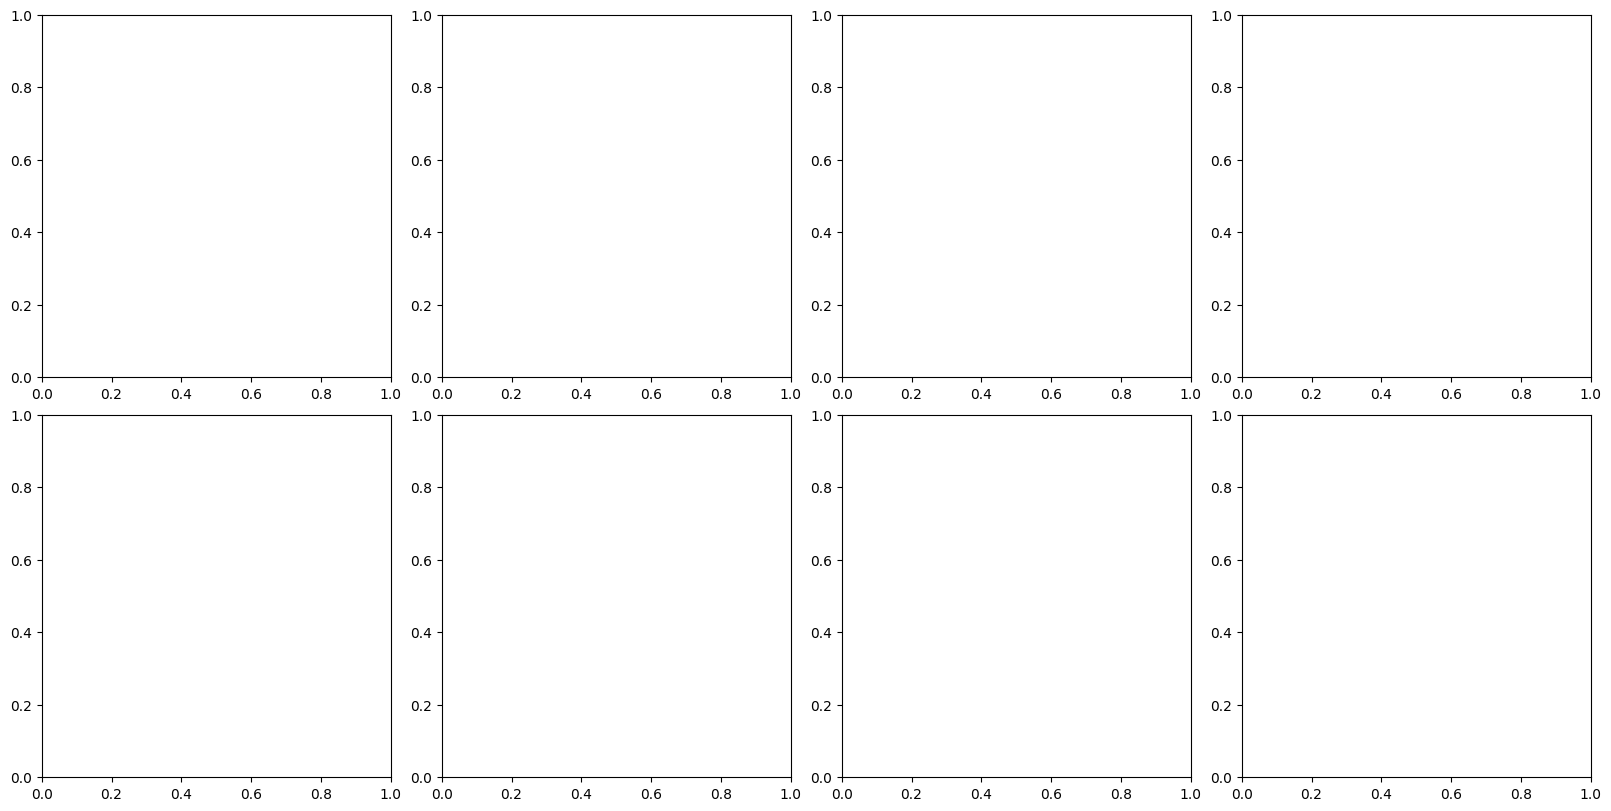

In [204]:
colors = sns.color_palette("hls", len(cmip_internal.model))
var_dict = {'tasmax': 'Daily maximum \n temperature', 'pr': 'Daily precipitation'}
fig, axs = plt.subplots(nrows=2,ncols=4, constrained_layout=True,figsize=(16,8))

count = 0
for iv, v in enumerate(cmip_internal['variable'].values):
    for i, s in enumerate(cmip_internal.scenario.values):
        ax = axs[iv, i]
        for m in range(len(cmip_internal.model)):
            ax.axhline(cmip_internal.sel(variable=v,region='region1',scenario=s).isel(model=m).I_FIT)
            ax.axhline(cmip_internal.sel(variable=v,region='region1',scenario=s).mean('model').I_FIT,color='r')
        ax.set_yscale('log')
        ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
        # ax.set_ylim(bottom=0)
        ax.set_title(f'{string.ascii_lowercase[count]}) {s} - {var_dict[v]}')
        ax.set_xlabel('')
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines["bottom"].set_position(("axes", -0.03)) 
        ax.spines["left"].set_position(("axes", -0.02))
#         ax.set_facecolor('0.95')
        count += 1
    
# Add a legend
labels=['Internal Variability Individual Models','Internal Variability Multi-Model Average']
# pos = axs.get_position()
# axs.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.85])
axs[0,1].legend(labels=labels,
    loc='upper center', 
    bbox_to_anchor=(1.1, 1.35),
    ncol=3, 
)
# labels=['Internal Variability Individual Models','Internal Variability Average']
# axs[0, 0].legend(labels=labels)
for ax in axs[:, 0]:
    ax.set_ylabel('Internal Variability FIT')
for ax in axs[:, 1]:
    ax.set_ylabel('')
for ax in axs[:, 2]:
    ax.set_ylabel('')
    
plt.subplots_adjust(left=0.06, right=0.99, bottom=0.07, top=0.8, wspace=0.30, hspace=0.30)  # all parameters MUST be specified for reproducibility!
# fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
fig.savefig('./plots/scenario_internal.png', dpi=200)


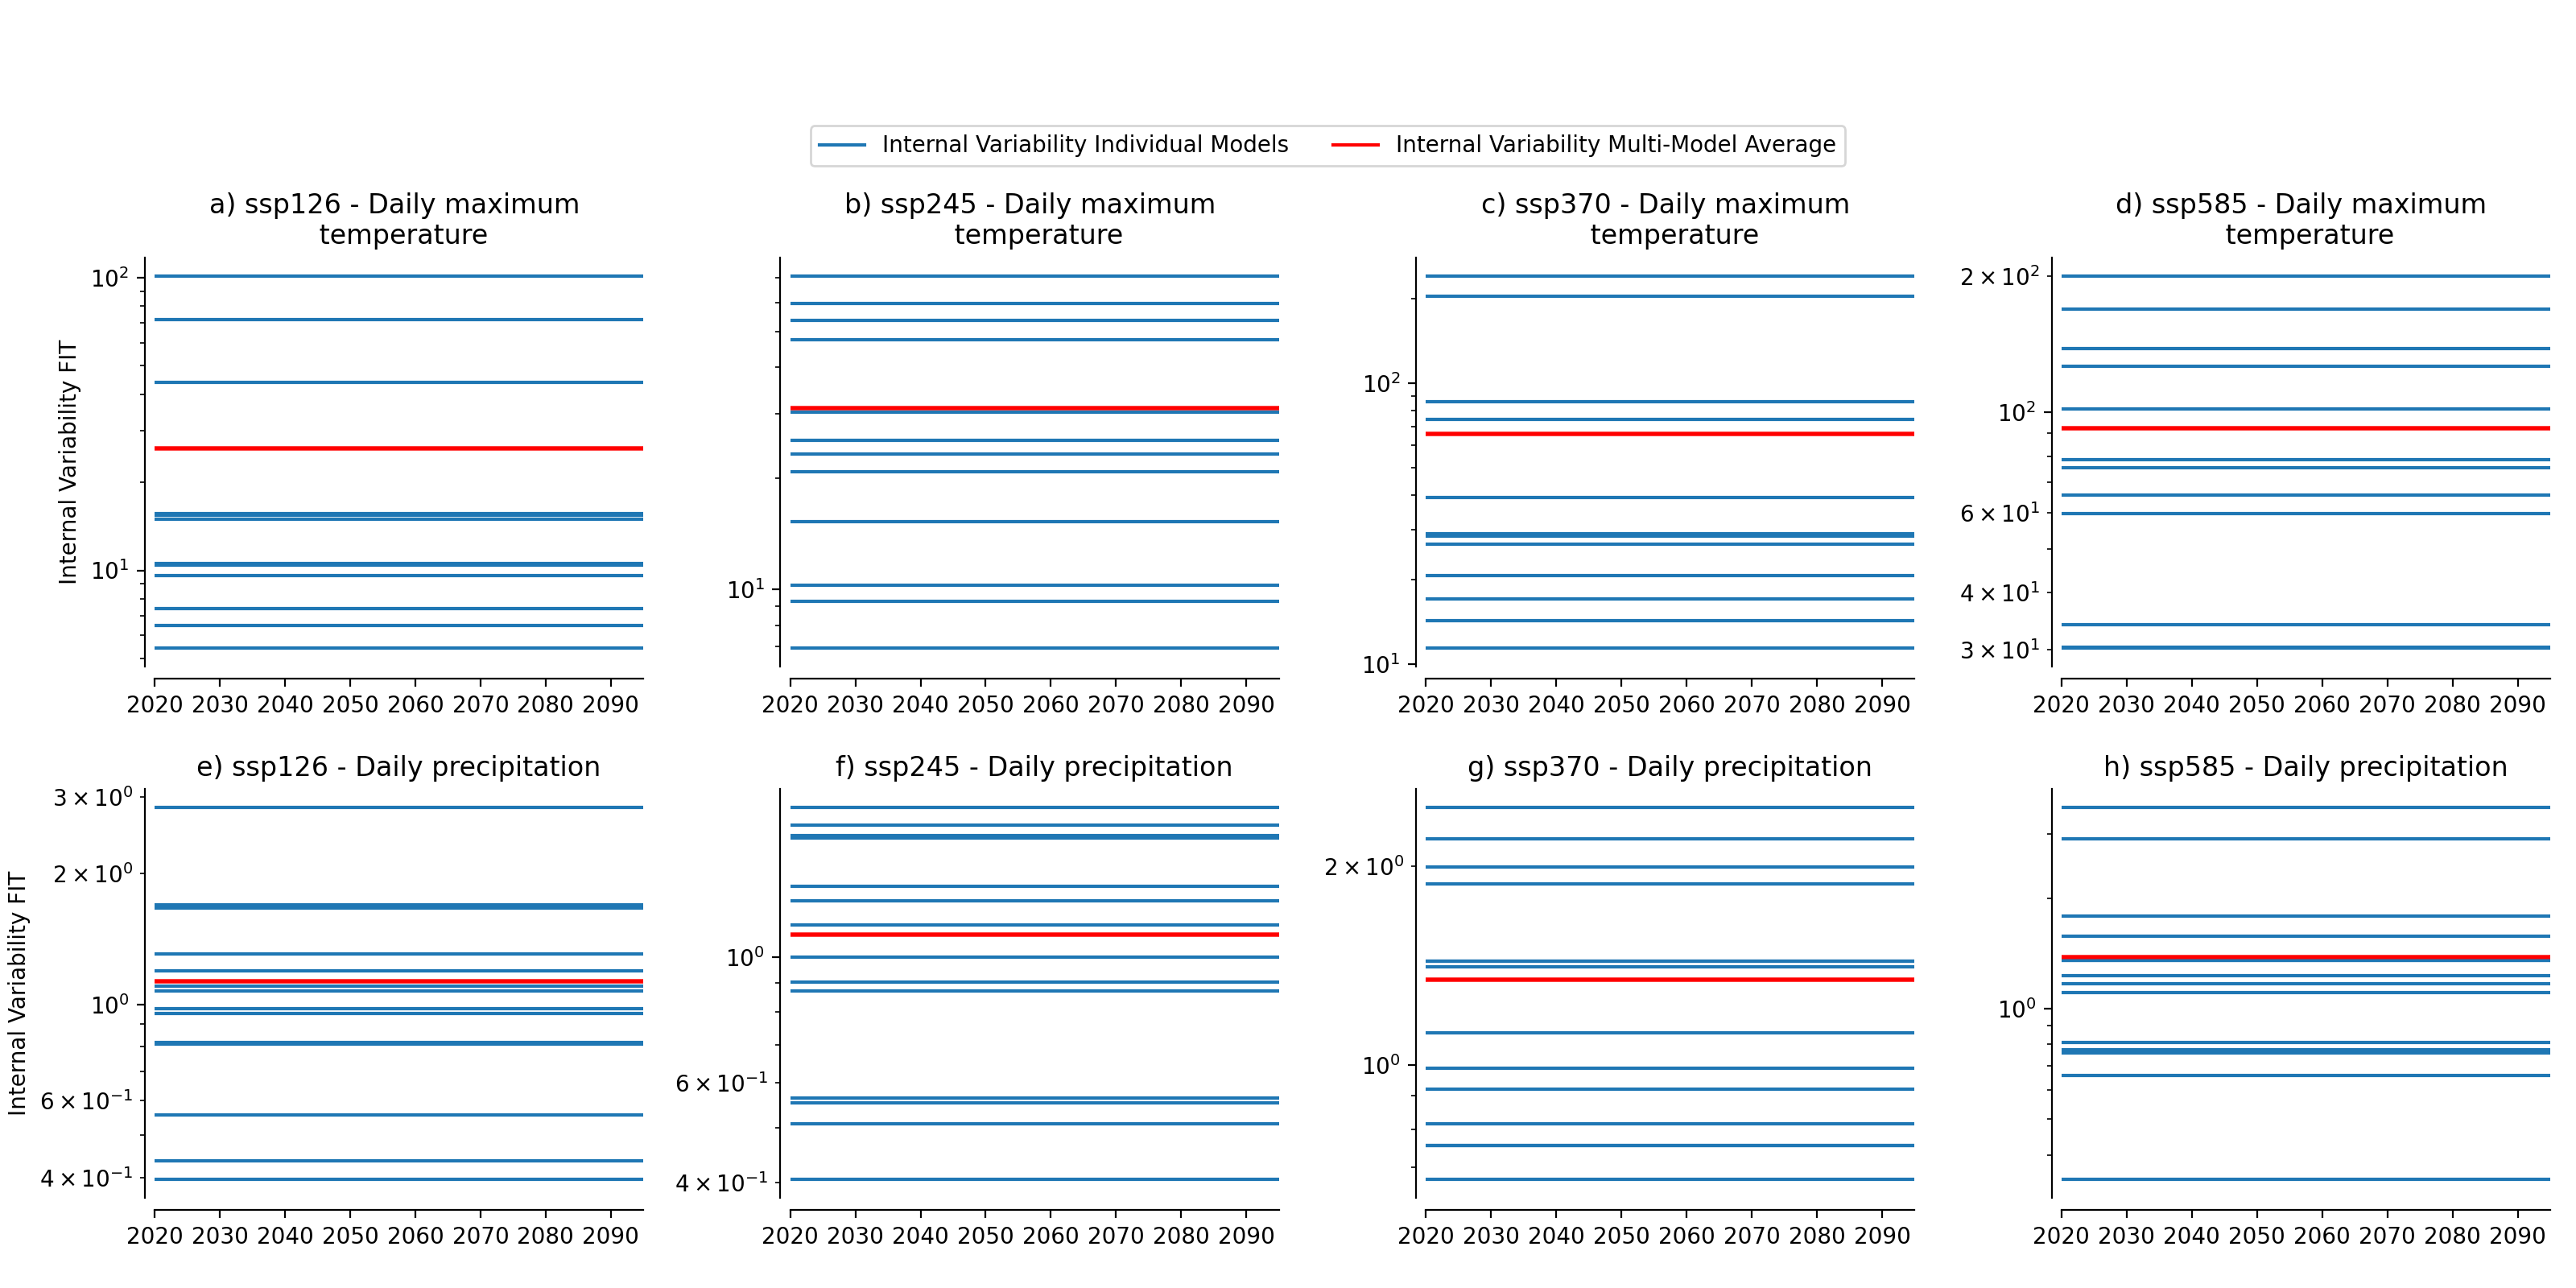

In [98]:
from IPython.display import Image
Image(filename='./plots/scenario_internal.png')   # Don't believe what Jupyter shows you!

NameError: name 'tas_scenario_results' is not defined

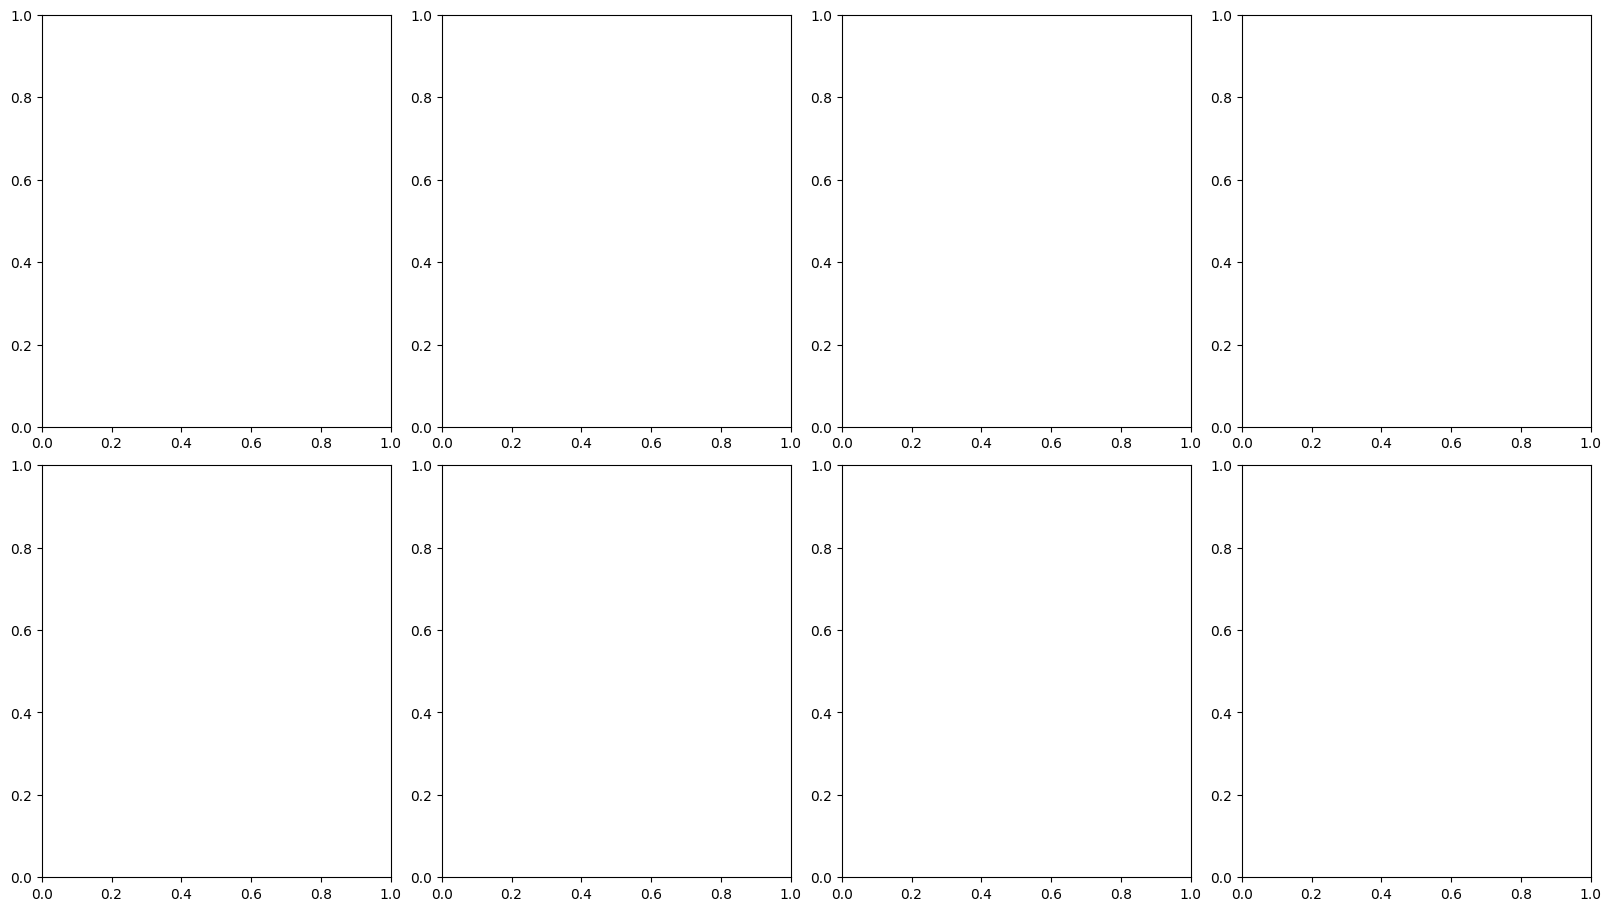

In [168]:
# scenario affect on variabilities for Europe 
fig,ax = plt.subplots(nrows=2,ncols=4, constrained_layout=True,figsize=(16,9))

axes = [ax[0,0],ax[0,1],ax[0,2],ax[0,3]]
titles = ['ssp126 tasmax','ssp245 tasmax','ssp370 tasmax','ssp585 tasmax']
for s,axis,t in zip(range(len(tas_scenario_results.scenario)),axes,titles):
    for m in range(len(tas_scenario_results.model)):
        axis.axhline(tas_scenario_results.isel(region=0,scenario=s,model=m).I_FIT)
        axis.axhline(tas_scenario_results.isel(region=0,scenario=s).Ibar_FIT,color='r')
        axis.plot(tas_scenario_results.isel(region=0,scenario=s).time,
                 tas_scenario_results.isel(region=0,scenario=s).M_FIT)
        axis.set_yscale('log')
        axis.set_title(t)
        labels = ['Internal','Internal FIT','Model Uncertainty']
        axis.legend(labels=labels)
        
axes = [ax[1,0],ax[1,1],ax[1,2],ax[1,3]]
titles = ['ssp126 pr','ssp245 pr','ssp370 pr','ssp585 pr']
for s,axis,t in zip(range(len(pr_scenario_results.scenario)),axes,titles):
    for m in range(len(pr_scenario_results.model)):
        axis.axhline(pr_scenario_results.isel(region=0,scenario=s,model=m).I_FIT)
        axis.axhline(pr_scenario_results.isel(region=0,scenario=s).Ibar_FIT,color='r')
        axis.plot(pr_scenario_results.isel(region=0,scenario=s).time,
                 pr_scenario_results.isel(region=0,scenario=s).M_FIT)
        axis.set_yscale('log')
        axis.set_title(t)
        labels = ['Internal','Internal FIT','Model Uncertainty']
        axis.legend(labels=labels)

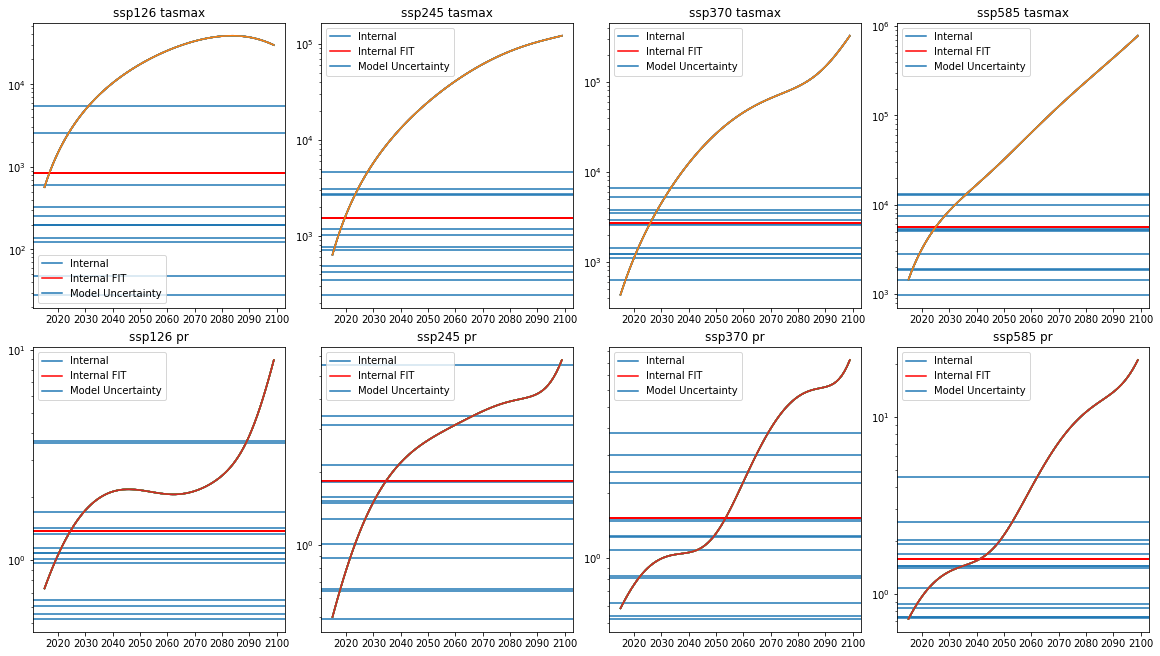

In [243]:
# scenario affect on variabilities for Tropics
fig,ax = plt.subplots(nrows=2,ncols=4, constrained_layout=True,figsize=(16,9))

axes = [ax[0,0],ax[0,1],ax[0,2],ax[0,3]]
titles = ['ssp126 tasmax','ssp245 tasmax','ssp370 tasmax','ssp585 tasmax']
for s,axis,t in zip(range(len(tas_scenario_results.scenario)),axes,titles):
    for m in range(len(tas_scenario_results.model)):
        axis.axhline(tas_scenario_results.isel(region=1,scenario=s,model=m).I_FIT)
        axis.axhline(tas_scenario_results.isel(region=1,scenario=s).Ibar_FIT,color='r')
        axis.plot(tas_scenario_results.isel(region=1,scenario=s).time,
                 tas_scenario_results.isel(region=1,scenario=s).M_FIT)
        axis.set_yscale('log')
        axis.set_title(t)
        labels = ['Internal','Internal FIT','Model Uncertainty']
        axis.legend(labels=labels)
        
axes = [ax[1,0],ax[1,1],ax[1,2],ax[1,3]]
titles = ['ssp126 pr','ssp245 pr','ssp370 pr','ssp585 pr']
for s,axis,t in zip(range(len(pr_scenario_results.scenario)),axes,titles):
    for m in range(len(pr_scenario_results.model)):
        axis.axhline(pr_scenario_results.isel(region=1,scenario=s,model=m).I_FIT)
        axis.axhline(pr_scenario_results.isel(region=1,scenario=s).Ibar_FIT,color='r')
        axis.plot(pr_scenario_results.isel(region=1,scenario=s).time,
                 pr_scenario_results.isel(region=1,scenario=s).M_FIT)
        axis.set_yscale('log')
        axis.set_title(t)
        labels = ['Internal','Internal FIT','Model Uncertainty']
        axis.legend(labels=labels)

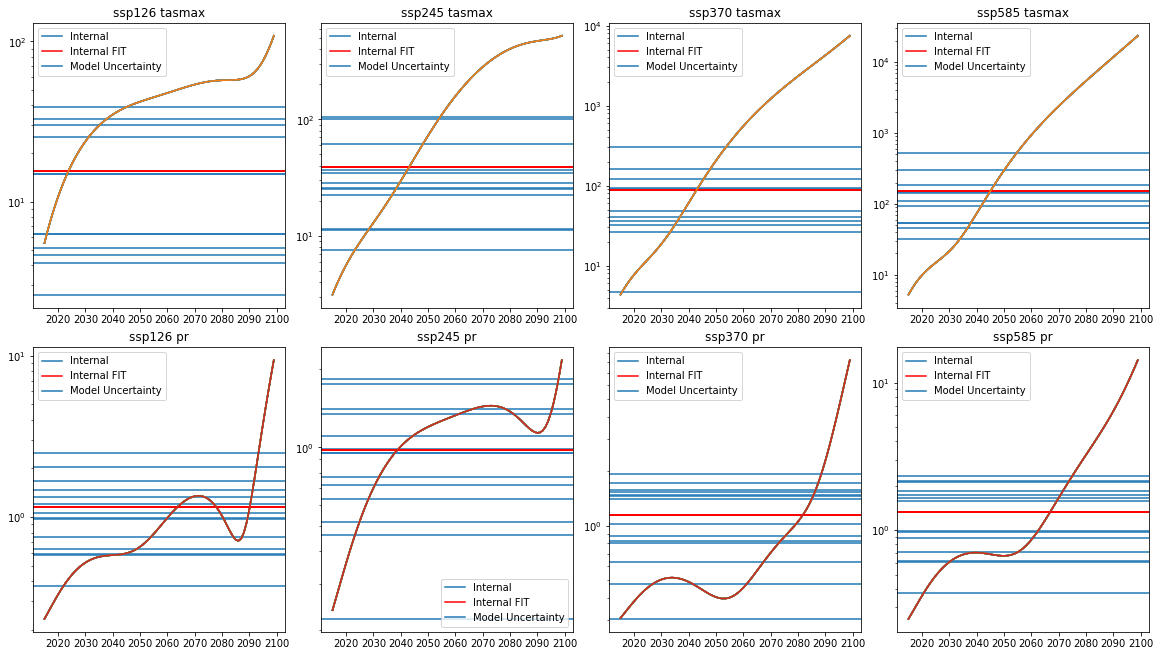

In [245]:
# scenario affect on variabilities for Australia 
fig,ax = plt.subplots(nrows=2,ncols=4, constrained_layout=True,figsize=(16,9))

axes = [ax[0,0],ax[0,1],ax[0,2],ax[0,3]]
titles = ['ssp126 tasmax','ssp245 tasmax','ssp370 tasmax','ssp585 tasmax']
for s,axis,t in zip(range(len(tas_scenario_results.scenario)),axes,titles):
    for m in range(len(tas_scenario_results.model)):
        axis.axhline(tas_scenario_results.isel(region=2,scenario=s,model=m).I_FIT)
        axis.axhline(tas_scenario_results.isel(region=2,scenario=s).Ibar_FIT,color='r')
        axis.plot(tas_scenario_results.isel(region=2,scenario=s).time,
                 tas_scenario_results.isel(region=2,scenario=s).M_FIT)
        axis.set_yscale('log')
        axis.set_title(t)
        labels = ['Internal','Internal FIT','Model Uncertainty']
        axis.legend(labels=labels)
        
axes = [ax[1,0],ax[1,1],ax[1,2],ax[1,3]]
titles = ['ssp126 pr','ssp245 pr','ssp370 pr','ssp585 pr']
for s,axis,t in zip(range(len(pr_scenario_results.scenario)),axes,titles):
    for m in range(len(pr_scenario_results.model)):
        axis.axhline(pr_scenario_results.isel(region=2,scenario=s,model=m).I_FIT)
        axis.axhline(pr_scenario_results.isel(region=2,scenario=s).Ibar_FIT,color='r')
        axis.plot(pr_scenario_results.isel(region=2,scenario=s).time,
                 pr_scenario_results.isel(region=2,scenario=s).M_FIT)
        axis.set_yscale('log')
        axis.set_title(t)
        labels = ['Internal','Internal FIT','Model Uncertainty']
        axis.legend(labels=labels)

## loading by location

In [3]:
# setting 
variable = 'tas'
# variable = 'tasmax'
# variable = 'pr'
models = ['MIROC6', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3','cesm_lens']

In [4]:
USwest = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
                               lat=37.7, lon=237.6, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [5]:
europe = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
                               lat=51, lon=10.5, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [6]:
australia = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
                               lat=-25.2, lon=133.7, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [7]:
tropics = MultiModelLargeEnsemble(models=models, variable=variable, granularity='day', 
                               lat=3.9, lon=306.9, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

### Compute variabilities 

In [20]:
USwest.compute_x(x_type='quantile_return',load=True,name='USwest_internal_tas')
USwest.compute_LE()
USwest.compute_FIT()
USwest_internal = USwest.results.squeeze()

In [17]:
europe.compute_x(x_type='quantile_return',load=False,name='europe_internal_tas')
europe.compute_LE()
europe.compute_FIT()
europe_internal = europe.results.squeeze()

100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

1.6518402099609375
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/europe_internal_tas/MIROC6.zarr



100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

1.6497039794921875
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/europe_internal_tas/CanESM5.zarr



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

1.65643310546875
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/europe_internal_tas/MPI-ESM1-2-LR.zarr



100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

1.6574783325195312
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/europe_internal_tas/EC-Earth3.zarr



100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

1.6640548706054688
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/europe_internal_tas/cesm_lens.zarr


In [18]:
australia.compute_x(x_type='quantile_return',load=False,name='australia_internal_tas')
australia.compute_LE()
australia.compute_FIT()
australia_internal = australia.results.squeeze()

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

1.6724472045898438
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/australia_internal_tas/MIROC6.zarr



100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

1.6681175231933594
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/australia_internal_tas/CanESM5.zarr



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

1.6689109802246094
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/australia_internal_tas/MPI-ESM1-2-LR.zarr



100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

1.6669464111328125
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/australia_internal_tas/EC-Earth3.zarr



100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

1.6953239440917969
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/australia_internal_tas/cesm_lens.zarr


In [19]:
tropics.compute_x(x_type='quantile_return',load=False,name='tropics_internal_tas')
tropics.compute_LE()
tropics.compute_FIT()
tropics_internal = tropics.results.squeeze()

100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

1.6721305847167969
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tropics_internal_tas/MIROC6.zarr



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

1.6629562377929688
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tropics_internal_tas/CanESM5.zarr



100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

1.6624069213867188
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tropics_internal_tas/MPI-ESM1-2-LR.zarr



100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

1.6800727844238281
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tropics_internal_tas/EC-Earth3.zarr



100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

1.6795692443847656
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tropics_internal_tas/cesm_lens.zarr


In [22]:
# merge datasets by region
regions = [USwest_internal,europe_internal,australia_internal,tropics_internal]
dss = []
for region in regions:
    internal = region.expand_dims('region')
    dss.append(internal)
regions = ['USwest','europe','australia','tropics']
internal = xr.concat(dss,dim='region')
internal = internal.assign_coords({'region':regions})

In [31]:
internal.time[95]

<xarray.DataArray 'time' ()>
array('2015-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2015-01-01

In [25]:
internal['M_LE_frac'] = (internal.M_LE/(internal.Ibar_LE+internal.M_LE))*100
internal['M_FIT_frac'] = (internal.M_FIT/(internal.Ibar_FIT+internal.M_FIT))*100
internal['I_LE_frac'] = (internal.Ibar_LE/(internal.Ibar_LE+internal.M_LE))*100
internal['I_FIT_frac'] = (internal.Ibar_FIT/(internal.Ibar_FIT+internal.M_FIT))*100

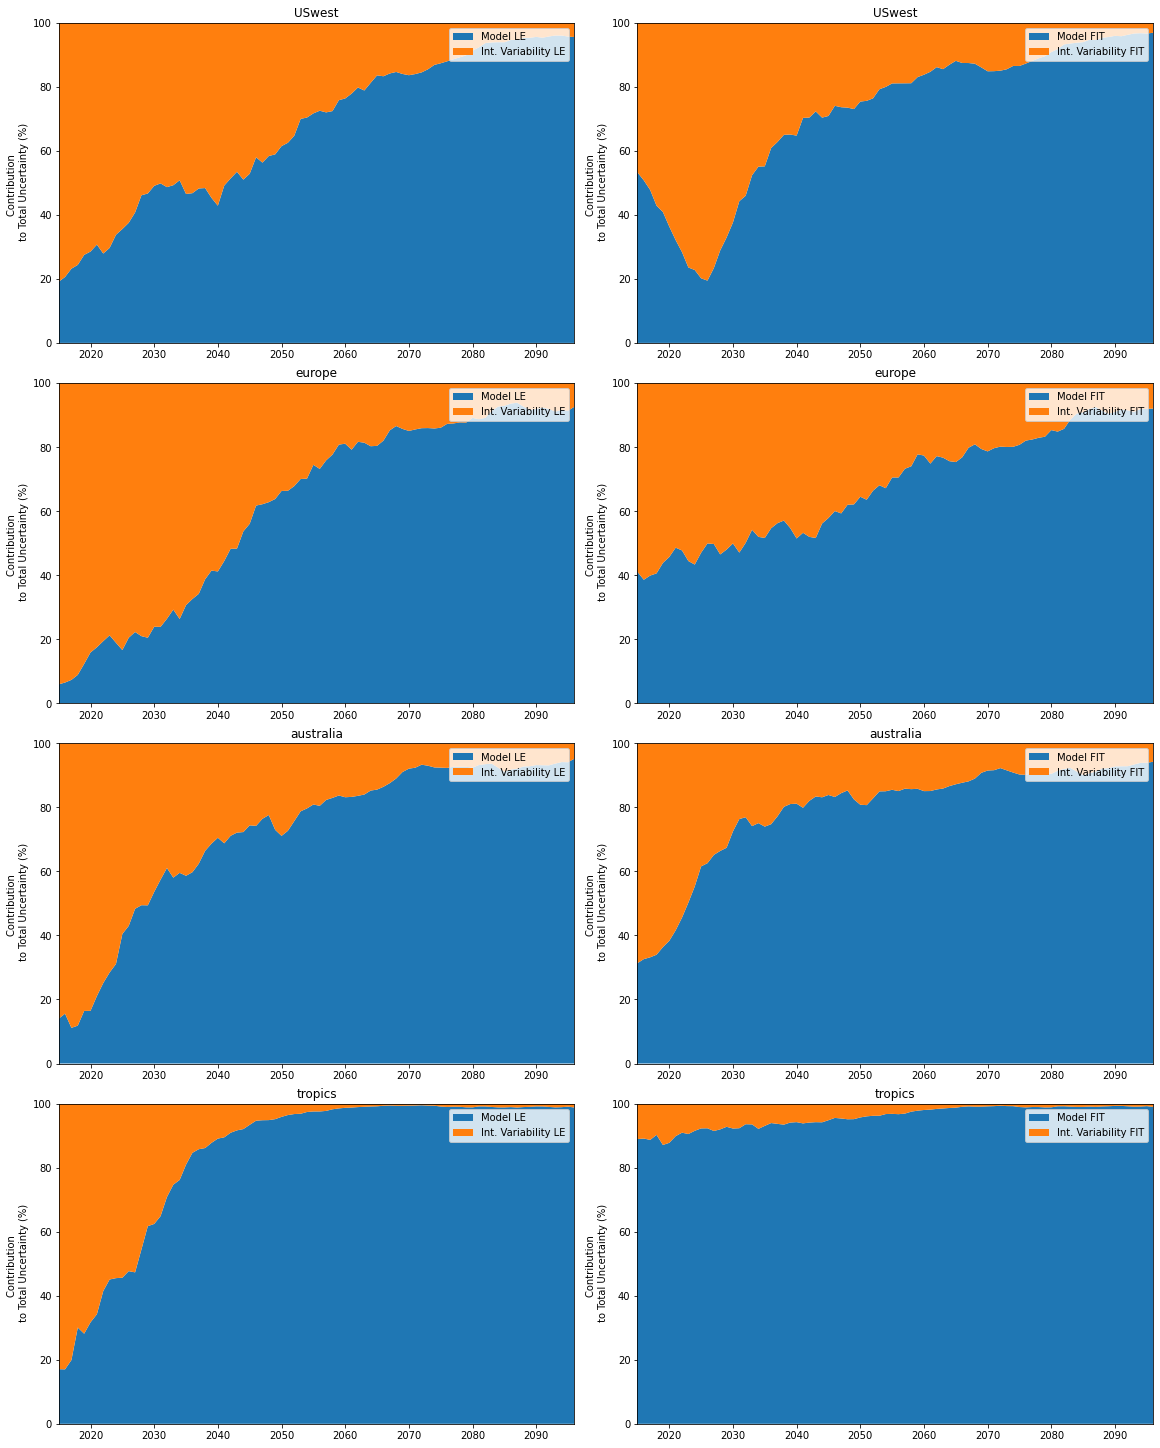

In [67]:
# INTERNAL MEAN
fig,ax = plt.subplots(nrows=4,ncols=2, constrained_layout=True,figsize=(16,20))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[1,0],ax[2,0],ax[3,0]]
for axis,region in zip(axes,regions):
    x=internal.sel(region=region).time
    y=internal.sel(region=region).M_LE_frac
    axis.fill_between(x,y,label='Model LE')
    # axis.plot(internal.sel(region=region).time,internal.sel(region=region).M_LE_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability LE')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[95],x[-5])
    
axes = [ax[0,1],ax[1,1],ax[2,1],ax[3,1]]
for axis,region in zip(axes,regions):
    x=internal.sel(region=region).time
    y=internal.sel(region=region).M_FIT_frac
    axis.fill_between(x,y,label='Model FIT')
    # axis.plot(internal.sel(region=region).time,internal.sel(region=region).M_FIT_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability FIT')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[95],x[-5])

In [33]:
internal

<xarray.Dataset>
Dimensions:     (time: 181, region: 4, model: 5, member_id: 71)
Coordinates:
  * time        (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
    lat         (region) float64 37.5 50.0 -25.0 5.0
    lon         (region) float64 237.5 10.0 132.5 307.5
  * model       (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
    quantile    (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    q_values    (region, model) float64 299.7 300.6 299.2 ... 303.0 301.9 300.1
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71
  * region      (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/13)
    M_LE        (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    I_LE        (region, model, time) float64 dask.array<chunksize=(1, 1, 181), meta=np.ndarray>
    Ibar_LE     (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    T_LE        (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    FIT         (region, time, model) float64 dask.array<chunksize=(1, 181, 1), meta=np.ndarray>
    M_FIT       (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    ...          ...
    Ibar_FIT    (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    T_FIT       (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    M_LE_frac   (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    M_FIT_frac  (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    I_LE_frac   (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>
    I_FIT_frac  (region, time) float64 dask.array<chunksize=(1, 181), meta=np.ndarray>

In [34]:
internal['total_LE'] = internal.Ibar_LE + internal.M_LE
internal['total_FIT'] = internal.Ibar_FIT + internal.M_FIT

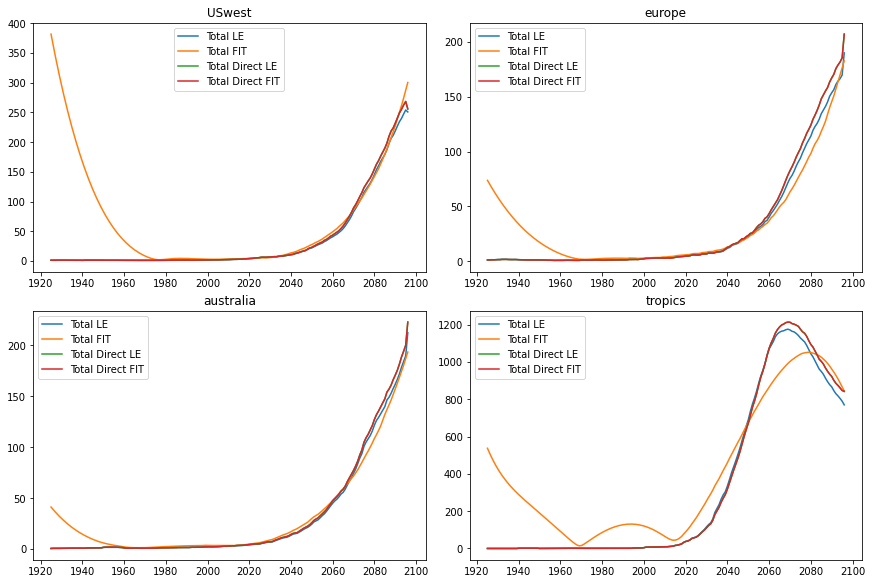

In [61]:
# INTERNAL MEAN
fig,ax = plt.subplots(nrows=2,ncols=2, constrained_layout=True,figsize=(12,8))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
for axis,r in zip(axes,regions):
    region = internal.sel(region=r)
    axis.plot(region.time,np.sqrt(region.total_LE), label = 'Total LE')
    axis.plot(region.time,np.sqrt(region.total_FIT),label='Total FIT')
    axis.plot(region.time,np.sqrt(region.T_LE),label='Total Direct LE')
    axis.plot(region.time,np.sqrt(region.T_FIT),label='Total Direct FIT')
    axis.legend()
    axis.set_title(r)
# what are these units??

In [78]:
USwest.x

<xarray.DataArray 'tas' (model: 5, member_id: 71, time: 181, lat: 1, lon: 1)>
dask.array<concatenate, shape=(5, 71, 181, 1, 1), dtype=float64, chunksize=(1, 71, 181, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * model      (model) <U13 'MIROC6' 'CanESM5' ... 'EC-Earth3' 'cesm_lens'
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat        (lat) float64 37.5
  * lon        (lon) float64 237.5
    q_values   (model, lat, lon) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    quantile   (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997

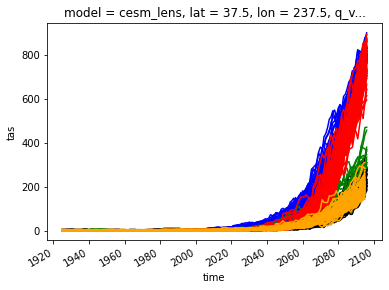

In [87]:
colors = ['k','b','g','r','orange']
for m in range(len(USwest.x.model)):
    USwest.x.squeeze().isel(model=m).plot(hue='member_id',add_legend=False,color=colors[m]);

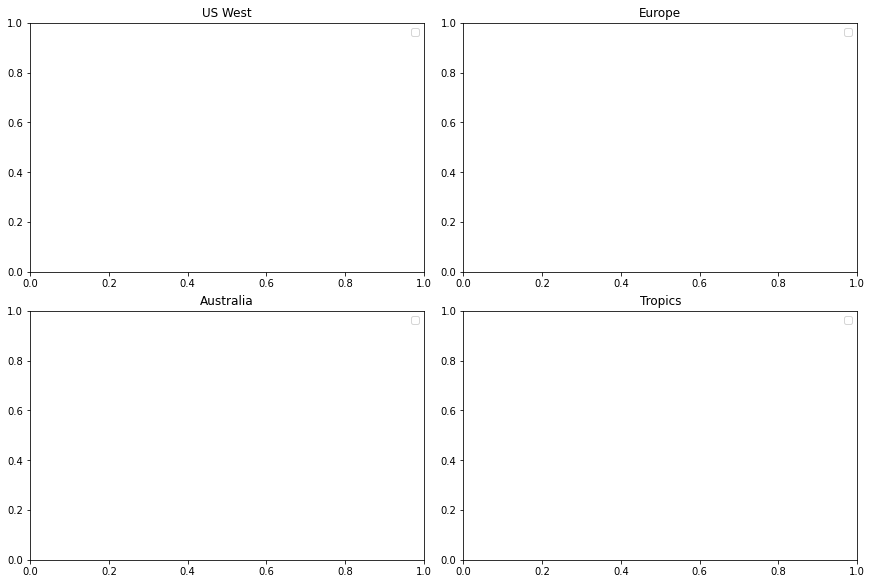

In [81]:
fig, axe = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(12,8))
regions = [USwest,europe,australia,tropics]
axes = [axe[0,0],axe[0,1],axe[1,0],axe[1,1]]
titles = ['US West', 'Europe', 'Australia', 'Tropics']
for r,a,t in zip(regions,axes,titles):
    for m in range(len(USwest.x.model)):
        a.plot(r.x.time,r.x.isel(model=m).squeeze().mean(dim=['member_id']))
        r.x.squeeze().isel(model=m).plot(hue='member_id',ax=axis)
    labels = ['MIROC6', 'CanESM5', 'MPI-ESM1-2-LR', 'EC-Earth3', 'cesm_lens']
    a.legend(labels=labels)
    a.set_title(t)